
## All necessary imports

In [1]:
# !cd tools/ && python setup_opera_distance_metric.py build_ext --inplace

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Sequential
from torch.distributions import Bernoulli
from torch.nn.utils import clip_grad_norm_

from tools.opera_distance_metric import generate_k_nearest_graph, \
                                        opera_distance_metric_py, \
                                        generate_radius_graph

from graph_rnn import bfs_seq, encode_adj, decode_adj

from torch.nn.utils.rnn import pack_padded_sequence, pack_sequence, pad_sequence, pad_packed_sequence
import random
from collections import namedtuple

sns.set(font_scale=2)

In [3]:
device = torch.device('cuda:0')

In [4]:
shower_adj = namedtuple('shower_adj', field_names=['x', 'adj', 'ele_p'])

import pickle

In [5]:
df = pickle.load(open("./data/showers_ship.pkl", "rb"))

In [6]:
def bfs_handmade(G, start):
    visited, queue = set(), [start]
    while queue:
        vertex = queue.pop(0)
        if vertex not in visited:
            visited.add(vertex)
            edges = sorted(G.out_edges(vertex, data=True), key=lambda x: x[2]['weight'])
            queue.extend(set([x[1] for x in edges]) - visited)
    return np.array(list(visited))[np.argsort(np.array(list(G.nodes())))]


def encode_adj(adj, max_prev_node=10, is_full = False):
    '''
    :param adj: n*n, rows means time step, while columns are input dimension
    :param max_degree: we want to keep row number, but truncate column numbers
    :return:
    '''
    if is_full:
        max_prev_node = adj.shape[0] - 1
    
    # successors only
    adj = adj
    
    # pick up lower tri
    adj = np.tril(adj, k=-1)
    n = adj.shape[0]
    adj = adj[1:n, 0:n-1]

    # use max_prev_node to truncate
    # note: now adj is a (n-1) * (n-1) matrix
    adj_output = np.zeros((adj.shape[0], max_prev_node))
    for i in range(adj.shape[0]):
        input_start = max(0, i - max_prev_node + 1)
        input_end = i + 1
        output_start = max_prev_node + input_start - input_end
        output_end = max_prev_node
        adj_output[i, output_start:output_end] = adj[i, input_start:input_end]
        adj_output[i,:] = adj_output[i,:][::-1] # reverse order

    return adj_output

## Model parameters

In [7]:
max_prev_node = 20
graph_state_size = 64
embedding_size = 256
edge_rnn_embedding_size = 64

In [23]:
batch_size = 50

In [24]:
graphrnn_shower = namedtuple('graphrnn_shower', field_names=['x', 
                                                             'adj', 
                                                             'adj_out', 
                                                             'adj_squared', 
                                                             'ele_p'])

In [53]:
max_prev_node=40
def preprocess_shower_for_graphrnn(shower, device, k=4):
    X = np.vstack([
        np.arange(len(shower.x.SX)),
        shower.x.TX,
        shower.x.TY,  
        shower.x.TZ, 
        shower.x.SX,
        shower.x.SY]
    ).T

    G = nx.DiGraph(shower.adj)

    adj = np.asarray(nx.to_numpy_matrix(nx.Graph(G)))

    start_idx = 0
    x_idx = np.array(bfs_seq(G, start_idx))
    adj = adj[np.ix_(x_idx, x_idx)]

    # actual data
    adj_output = encode_adj(adj, max_prev_node=max_prev_node)
    adj_recover = decode_adj(adj_output)
    print('error', np.sum(np.abs(adj_recover - adj)))


    X = X[x_idx, 1:]
    X = X / np.array([1e3, 1e3, 1e3, 1, 1])
    
    # for now forget about distances
    # TODO: what to do with distances?
    adj_output[adj_output!=0] = 1.
    
    adj_output_t = torch.tensor(np.append(np.ones((1, max_prev_node)), 
                                          adj_output, axis=0), 
                                dtype=torch.float32).to(device).view(1, -1, max_prev_node)
    
    X_t = torch.tensor(X, dtype=torch.float32).to(device).view(1, -1, 5)

    adj_out_t = torch.LongTensor(np.array(list(nx.from_numpy_matrix(decode_adj(adj_output), 
                                                                    create_using=nx.DiGraph).edges())).T).to(device)
    
    adj_squared_t = torch.tensor(adj, dtype=torch.float32).to(device)
    
    return graphrnn_shower(adj=adj_output_t, 
                           x=X_t, 
                           adj_out=adj_out_t,
                           adj_squared=adj_squared_t,
                           ele_p=torch.tensor(shower.ele_p, dtype=torch.float32).to(device))

In [54]:
%%time
showers_train = []
for shower in df[:3]:
    showers_train.append(preprocess_shower_for_graphrnn(shower, device=device, k=3))

error 0.0
error 0.0
error 0.0
CPU times: user 116 ms, sys: 0 ns, total: 116 ms
Wall time: 115 ms


#### GraphRNN 

Generates embeddings for nodes.

In [55]:
class GraphRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, 
                 num_layers, has_input=True, has_output=False, output_size=None):
        super(GraphRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.has_input = has_input
        self.has_output = has_output

        if has_input:
            self.input = nn.Linear(input_size, embedding_size)
            self.rnn = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, 
                              num_layers=num_layers, batch_first=True)
        else:
            self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                              num_layers=num_layers, batch_first=True)
        if has_output:
            self.output = nn.Sequential(
                nn.Linear(hidden_size, embedding_size),
                nn.ReLU(),
                nn.Linear(embedding_size, output_size)
            )

        self.relu = nn.ReLU()
        # initialize
        self.hidden_emb = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.hidden_size)
        )
        self.hidden = None  # need initialize before forward run

    def init_hidden(self, input, batch_size):
        hidden_emb = torch.cat([self.hidden_emb(input).view(1, batch_size, self.hidden_size), 
                                torch.zeros(self.num_layers - 1, batch_size, self.hidden_size).cuda()])
        return hidden_emb

    def forward(self, input_raw, pack=False, input_len=None):
        output_raw_emb, output_raw, output_len = None, None, None
        
        if self.has_input:
            input = self.input(input_raw)
            input = self.relu(input)
        else:
            input = input_raw
        if pack:
            
            pass # input = pack_sequence(input)
        
        output_raw_emb, self.hidden = self.rnn(input, self.hidden)
        if pack:
            output_raw_emb, output_len = pad_packed_sequence(output_raw_emb, batch_first=True)
        
        if self.has_output:
            output_raw = self.output(output_raw_emb)
            
        if pack:
            output_raw_packed = pack_padded_sequence(output_raw, lengths=output_len, batch_first=True)
            return output_raw_emb, output_raw, output_len
        
        # return hidden state at each time step
        return output_raw_emb, output_raw, output_len

In [56]:
model = GraphRNN(input_size=max_prev_node, 
                 embedding_size=max_prev_node, 
                 output_size=edge_rnn_embedding_size, 
                 has_output=True, 
                 hidden_size=embedding_size, 
                 num_layers=4, 
                 has_input=False).to(device)

### Edge network

In [57]:
edge_nn = GraphRNN(input_size=1, 
                   embedding_size=edge_rnn_embedding_size,
                   hidden_size=edge_rnn_embedding_size, 
                   num_layers=4, has_input=True, has_output=True, 
                   output_size=1).to(device)

### FeaturesGCN

In [58]:
import torch_geometric.transforms as T
import torch_cluster
import torch_geometric

from torch_geometric.nn import NNConv, GCNConv, GraphConv
from torch_geometric.nn import PointConv, EdgeConv, SplineConv


class FeaturesGCN(torch.nn.Module):
    def __init__(self, dim_in, embedding_size=128, num_layers=4, dim_out=6):
        super().__init__()
        
        self.wconv_in = EdgeConv(Sequential(nn.Linear(dim_in * 2, embedding_size)), 'max')
        
        self.layers = nn.ModuleList(modules=[EdgeConv(Sequential(nn.Linear(embedding_size * 2, embedding_size)), 'max')
                                   for i in range(num_layers)])

        self.wconv_out = EdgeConv(Sequential(nn.Linear(embedding_size * 2, dim_out)), 'max')

        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.wconv_in(x=x, edge_index=edge_index)
        
        for l in self.layers:
            x = l(x=x, edge_index=edge_index)
        
        x = self.wconv_out(x=x, edge_index=edge_index)
        
        return x

In [59]:
features_nn = FeaturesGCN(dim_in=edge_rnn_embedding_size * max_prev_node, 
                          embedding_size=128, num_layers=4,
                          dim_out=5).to(device=device)

#### Losses

In [60]:
sigmoid = nn.Sigmoid().to(device)
loss_bce = nn.BCELoss().to(device)
loss_mse = torch.nn.MSELoss().to(device)

def loss_mse_edges(shower, features):
    return loss_mse((shower.x[0][shower.adj_out[0]] - shower.x[0][shower.adj_out[1]]), 
                    (features[shower.adj_out[0]] - features[shower.adj_out[1]]))

### process_train_graphrnn

In [61]:
from torch.nn.utils.rnn import PackedSequence

def process_train_graphrnn(showers_batch):
    batch_size = len(showers_batch)
    
    model.hidden = model.init_hidden(input=torch.stack([x.ele_p for x in showers_batch]).view(-1, 1), 
                                     batch_size=batch_size)
    
    packed_adj_batch = pack_sequence([x.adj[0] for x in showers_batch])
    _, embedding_batch, output_len = model(packed_adj_batch, pack=True)

    packed_embedding_batch = pack_padded_sequence(embedding_batch, output_len, batch_first=True).data
    
    hidden_null = torch.zeros(4 - 1, packed_embedding_batch.shape[0], packed_embedding_batch.shape[1]).to(device)
    
    edge_nn.hidden = torch.cat((packed_embedding_batch.view(1, 
                                                            packed_embedding_batch.size(0), 
                                                            packed_embedding_batch.size(1)), hidden_null), dim=0)
    
    packed_adj_batch_data = packed_adj_batch.data
    packed_adj_batch_data = packed_adj_batch_data.view(packed_adj_batch_data.shape[0], 
                                                       packed_adj_batch_data.shape[1], 1)
    
    packed_adj_batch = torch.cat((torch.ones(packed_adj_batch_data.shape[0], 1, 1).to(device), 
                                  packed_adj_batch_data[:, 0:-1, 0:1]), dim=1)
    edges_emb, edges, _ = edge_nn(packed_adj_batch)
    return embedding_batch, output_len, \
           pad_packed_sequence(PackedSequence(edges_emb.contiguous().view(edges_emb.size(0), -1), output_len))[0], \
           loss_bce(torch.sigmoid(edges), packed_adj_batch_data)

In [62]:
showers_batch = showers_train
showers_batch = sorted(showers_batch, key=lambda x: -x.adj.shape[1])

In [63]:
embedding_batch, output_len, edges, ll_bce = process_train_graphrnn(showers_batch)

### Optimization of edge predictions

In [64]:
from itertools import chain

learning_rate = 1e-5
optimizer_bce = torch.optim.Adam(list(model.parameters()) + 
                                 list(edge_nn.parameters()), 
                                 lr=learning_rate)

In [76]:
model.train()
edge_nn.train()

for i in tqdm(range(200)):
    optimizer_bce.zero_grad()
    
    showers_batch = showers_train # random.sample(showers_train, batch_size)
    showers_batch = sorted(showers_batch, key=lambda x: -x.adj.shape[1])
    
    # iterate over showers in batch
    # and calc losses
    embedding_batch, output_len, edges_emb, ll_bce = process_train_graphrnn(showers_batch)

    ll_bce.backward()
    
    optimizer_bce.step()
    
    print(ll_bce.item())
    
    del embedding_batch, output_len

RuntimeError: cuda runtime error (39) : uncorrectable ECC error encountered at /opt/conda/conda-bld/pytorch_1544174967633/work/aten/src/THC/generic/THCTensorMath.cu:24

### Optimization of feature reconstruction

In [66]:
features_nn = FeaturesGCN(dim_in=edge_rnn_embedding_size * max_prev_node, 
                          embedding_size=128, num_layers=3,
                          dim_out=5).to(device=device)

In [71]:
learning_rate = 1e-4
optimizer_mse = torch.optim.Adam(list(features_nn.parameters()) +
                                  list(edge_nn.parameters()) +
                                  list(model.parameters()), 
                                 lr=learning_rate)

In [72]:
all_params = list(features_nn.parameters()) + list(edge_nn.parameters()) + list(model.parameters())

In [73]:
from torch.nn.utils import clip_grad_norm_
model.train()
edge_nn.train()

for i in tqdm(range(3000)):
    optimizer_mse.zero_grad()
    
    showers_batch = showers_train # random.sample(showers_train, batch_size)
    showers_batch = sorted(showers_batch, key=lambda x: -x.adj.shape[1])
    
    # iterate over showers in batch
    # and calc losses
    _, output_len, edges_emb, ll_bce = process_train_graphrnn(showers_batch)
    
    ll_mse_edges = []
    
    # iterate over showers in batch
    # and calc losses
    for k, l in enumerate(output_len):
        shower = showers_batch[k]
        
        embedding = edges_emb[k][:l]

        # teacher forcing
        shower_t = torch_geometric.data.Data(x=embedding, 
                                             edge_index=shower.adj_out).to(device)
        
        # GCN to recover shower features
        features = features_nn(shower_t)
    
        # features prediction loss        
        ll_mse_edges.append(loss_mse_edges(shower, features))
        
        del shower_t, features

    ll_mse_edges = sum(ll_mse_edges) / len(ll_mse_edges)
    
    ll_mse_edges.backward()
    clip_grad_norm_(all_params, 0.1)
    optimizer_mse.step()
    
    del edges_emb, output_len
    
    print(ll_bce.item(), 
          ll_mse_edges.item())

0.7557439804077148 6.651609420776367
0.7557543516159058 6.6386542320251465
0.7557647228240967 6.6251726150512695
0.7557784914970398 6.611886024475098
0.7557989358901978 6.599609375
0.7558250427246094 6.588953971862793
0.7558570504188538 6.579643249511719
0.7558942437171936 6.570761680603027
0.7559349536895752 6.5625834465026855
0.7559771537780762 6.554551124572754
0.7560217976570129 6.546661376953125
0.756068229675293 6.538860321044922
0.7561114430427551 6.53121280670166
0.756149411201477 6.523470878601074
0.7561818957328796 6.515540599822998
0.7562079429626465 6.507549285888672
0.756230354309082 6.499896049499512
0.7562519311904907 6.491856575012207
0.7562751173973083 6.483619213104248
0.7563015818595886 6.474870681762695
0.7563301920890808 6.4664530754089355
0.7563583850860596 6.458339214324951
0.7563856840133667 6.449931621551514
0.75641268491745 6.441842555999756
0.7564409375190735 6.434229850769043
0.7564681768417358 6.42816686630249
0.7564880847930908 6.421111583709717
0.75650054

0.7604659199714661 5.338425636291504
0.7604818344116211 5.365695476531982
0.7605766654014587 5.321846961975098
0.7607339024543762 5.355525970458984
0.7608042359352112 5.3969268798828125
0.7608000636100769 5.335556983947754
0.7607230544090271 5.321745872497559
0.7607173323631287 5.350326061248779
0.7607895135879517 5.307762145996094
0.7609225511550903 5.343408107757568
0.7609779238700867 5.385619640350342
0.7609643936157227 5.3230743408203125
0.760879397392273 5.307680130004883
0.7608758807182312 5.336764812469482
0.7609495520591736 5.29464054107666
0.7610940337181091 5.327950477600098
0.7611594200134277 5.369606971740723
0.7611556649208069 5.309829235076904
0.7610868215560913 5.293400764465332
0.761094331741333 5.3224945068359375
0.7611771821975708 5.280568599700928
0.7613227963447571 5.320018768310547
0.7614063024520874 5.3627028465271
0.7614256143569946 5.302370548248291
0.7613756060600281 5.276066780090332
0.7613868713378906 5.306955337524414
0.7614500522613525 5.272714614868164
0.7

0.7669734358787537 4.927799224853516
0.7668857574462891 4.955751419067383
0.7669181227684021 4.94642448425293
0.7670667767524719 4.92877197265625
0.7670872211456299 4.921562194824219
0.7669858336448669 4.950944900512695
0.7670032978057861 4.941348075866699
0.7671334743499756 4.922877311706543
0.7671422958374023 4.915745735168457
0.7670392394065857 4.946413993835449
0.7670605182647705 4.9374189376831055
0.7671971917152405 4.915743827819824
0.7672097682952881 4.9087910652160645
0.7671123147010803 4.942759990692139
0.767145574092865 4.933326244354248
0.7673025131225586 4.909126281738281
0.7673283815383911 4.902225494384766
0.7672333121299744 4.938446044921875
0.7672684192657471 4.928616523742676
0.7674249410629272 4.9030256271362305
0.7674416899681091 4.896169662475586
0.7673285007476807 4.933585166931152
0.7673425674438477 4.922725200653076
0.7674891948699951 4.898262023925781
0.7675111293792725 4.89105749130249
0.7674111127853394 4.927867889404297
0.7674386501312256 4.917344570159912
0.

KeyboardInterrupt: 

### Finetuning

In [74]:
learning_rate = 1e-5
optimizer_fine = torch.optim.Adam(list(features_nn.parameters()) +
                                  list(edge_nn.parameters()) +
                                  list(model.parameters()), lr=learning_rate)

In [75]:
model.train()
edge_nn.train()
for i in tqdm(range(200000)):
    optimizer_fine.zero_grad()
    
    showers_batch = showers_train # random.sample(showers_train, batch_size)
    showers_batch = sorted(showers_batch, key=lambda x: -x.adj.shape[1])
    
    # iterate over showers in batch
    # and calc losses
    _, output_len, edges_emb, ll_bce = process_train_graphrnn(showers_batch)
    
    ll_mse_edges = []
    
    # iterate over showers in batch
    # and calc losses
    for k, l in enumerate(output_len):
        shower = showers_batch[k]
        
        embedding = edges_emb[k][:l]

        # teacher forcing
        shower_t = torch_geometric.data.Data(x=embedding, 
                                             edge_index=shower.adj_out).to(device)
        
        # GCN to recover shower features
        features = features_nn(shower_t)
    
        # features prediction loss        
        ll_mse_edges.append(loss_mse_edges(shower, features))
        
        del shower_t, features

    ll_mse_edges = sum(ll_mse_edges) / len(ll_mse_edges)
    
    (ll_bce + ll_mse_edges).backward()
    
    optimizer_fine.step()
    
    print(ll_bce.item(), 
          ll_mse_edges.item())

0.7679104208946228 4.8832807540893555
0.7678842544555664 4.87148380279541
0.767651379108429 4.877440452575684
0.7673547267913818 4.847408294677734
0.7670437693595886 4.8463287353515625
0.7667439579963684 4.861194610595703
0.7664757966995239 4.8564300537109375
0.7662340402603149 4.842724800109863
0.765999972820282 4.840858459472656
0.7657548189163208 4.848179817199707
0.7654918432235718 4.849734783172607
0.7652145028114319 4.8431291580200195
0.7649297714233398 4.83790397644043
0.7646440267562866 4.839284420013428
0.7643658518791199 4.843024730682373
0.7641002535820007 4.842148780822754
0.7638470530509949 4.837258338928223
0.7636021375656128 4.8346099853515625
0.7633577585220337 4.83643102645874
0.7631088495254517 4.838109016418457
0.7628549933433533 4.83619499206543
0.7625963091850281 4.832850456237793
0.7623372673988342 4.832026958465576
0.762080729007721 4.833375930786133
0.7618297338485718 4.833523273468018
0.7615849375724792 4.8314313888549805
0.7613439559936523 4.829476356506348
0.

0.7152734994888306 4.641618728637695
0.715019702911377 4.640475749969482
0.714779794216156 4.639277935028076
0.7145254611968994 4.638049602508545
0.7142789363861084 4.636751174926758
0.7140296101570129 4.635396957397461
0.7137778401374817 4.634159088134766
0.7135323882102966 4.632988929748535
0.7132765650749207 4.631924629211426
0.7130299210548401 4.6306867599487305
0.7127753496170044 4.629427909851074
0.7125219106674194 4.628049850463867
0.7122728824615479 4.6268205642700195
0.7120130658149719 4.625619411468506
0.7117632627487183 4.624480724334717
0.7115025520324707 4.623254776000977
0.7112398743629456 4.62192440032959
0.7109783887863159 4.620622634887695
0.7107133865356445 4.619344234466553
0.710447371006012 4.618260383605957
0.7101781964302063 4.617190837860107
0.7099131941795349 4.616013050079346
0.7096364498138428 4.614651679992676
0.7093735933303833 4.613397598266602
0.7090933322906494 4.612070083618164
0.7088245153427124 4.610763072967529
0.7085492014884949 4.609553337097168
0.7

0.6490521430969238 4.380154609680176
0.6487270593643188 4.378970146179199
0.648445188999176 4.377806663513184
0.6480867862701416 4.377521514892578
0.6478332877159119 4.377551078796387
0.6474376916885376 4.3759379386901855
0.6471521854400635 4.373668670654297
0.6468322277069092 4.37192440032959
0.6465176939964294 4.371010780334473
0.6462116241455078 4.370665550231934
0.6458532214164734 4.3697896003723145
0.6455965042114258 4.368574142456055
0.6452553868293762 4.367124557495117
0.6449806094169617 4.366011619567871
0.6446422934532166 4.364690780639648
0.6443238258361816 4.363277435302734
0.6440017819404602 4.361879348754883
0.6436862945556641 4.360684394836426
0.6433642506599426 4.359794616699219
0.643036961555481 4.358778476715088
0.6427257657051086 4.357571601867676
0.6424310803413391 4.356203556060791
0.6421003341674805 4.354970932006836
0.6418006420135498 4.3544206619262695
0.6414360404014587 4.3545026779174805
0.6411840915679932 4.354331970214844
0.6407932639122009 4.353494644165039


0.5749366283416748 4.149533748626709
0.57453453540802 4.149320602416992
0.5742173790931702 4.149170875549316
0.5737626552581787 4.148617744445801
0.5734378099441528 4.147173881530762
0.5730368494987488 4.145229816436768
0.5727390050888062 4.1435465812683105
0.5723682641983032 4.142437934875488
0.5719927549362183 4.14182186126709
0.5716511607170105 4.141491889953613
0.571221113204956 4.141139030456543
0.5709306001663208 4.1401262283325195
0.5704952478408813 4.138785362243652
0.5701716542243958 4.137460708618164
0.5698055028915405 4.136113166809082
0.5695130825042725 4.135074138641357
0.5690909028053284 4.134889602661133
0.5687505006790161 4.134149074554443
0.568341851234436 4.1328535079956055
0.5680239796638489 4.131547451019287
0.5676743388175964 4.130335807800293
0.5673454999923706 4.128889083862305
0.5669528841972351 4.127652645111084
0.5666287541389465 4.127204895019531
0.5661852359771729 4.1266984939575195
0.5658867359161377 4.125087738037109
0.5655510425567627 4.124215126037598
0.

0.5028021931648254 3.9593138694763184
0.502467155456543 3.95888090133667
0.5023110508918762 3.958993673324585
0.5018892884254456 3.9581732749938965
0.5016975402832031 3.957318067550659
0.5013388991355896 3.956958770751953
0.5011319518089294 3.956956386566162
0.5006909370422363 3.9580142498016357
0.5005379319190979 3.957127332687378
0.5001345872879028 3.9553515911102295
0.4999159872531891 3.9534926414489746
0.49958792328834534 3.951211452484131
0.499321848154068 3.9494590759277344
0.49902695417404175 3.9488730430603027
0.4987710118293762 3.948424816131592
0.49845725297927856 3.9478583335876465
0.4981191158294678 3.9475255012512207
0.49794161319732666 3.947422742843628
0.49756690859794617 3.9464640617370605
0.4973774254322052 3.94527006149292
0.49704742431640625 3.9445769786834717
0.49678102135658264 3.9443163871765137
0.4964788258075714 3.9426820278167725
0.4962378442287445 3.9413676261901855
0.4958927631378174 3.940744400024414
0.4956873953342438 3.939582586288452
0.49537697434425354 3

0.44609400629997253 3.8091723918914795
0.4456758499145508 3.8064231872558594
0.4455898404121399 3.8050217628479004
0.445270299911499 3.804403066635132
0.4450456500053406 3.804832935333252
0.4449533522129059 3.8070664405822754
0.44459158182144165 3.803581953048706
0.44443127512931824 3.8012008666992188
0.4441883862018585 3.7993907928466797
0.44391268491744995 3.7985970973968506
0.44370806217193604 3.7994461059570312
0.4434649646282196 3.8005318641662598
0.44324949383735657 3.799936056137085
0.44290801882743835 3.7983365058898926
0.4427909553050995 3.796276807785034
0.44251129031181335 3.7942605018615723
0.4422977566719055 3.794116735458374
0.44217461347579956 3.796266555786133
0.441832572221756 3.7960615158081055
0.4416620433330536 3.7951459884643555
0.4413699507713318 3.793160915374756
0.4411262571811676 3.7910232543945312
0.44090360403060913 3.789712429046631
0.44075626134872437 3.7900967597961426
0.4404996633529663 3.7900779247283936
0.44028303027153015 3.7892842292785645
0.440066605

0.3992876410484314 3.678107261657715
0.39915990829467773 3.6795096397399902
0.39889198541641235 3.6794419288635254
0.39866340160369873 3.6798043251037598
0.3984518051147461 3.6783454418182373
0.3982818126678467 3.675767660140991
0.3980478048324585 3.6750264167785645
0.39787209033966064 3.673780918121338
0.39756837487220764 3.6726770401000977
0.39738696813583374 3.672123670578003
0.39724889397621155 3.6728763580322266
0.3969537615776062 3.671872615814209
0.39675718545913696 3.6713290214538574
0.39661702513694763 3.6708946228027344
0.3963583707809448 3.67012357711792
0.3961493670940399 3.669271230697632
0.39587682485580444 3.6681408882141113
0.39575040340423584 3.668646812438965
0.3954574167728424 3.6703031063079834
0.3954175114631653 3.674161911010742
0.39504438638687134 3.6748080253601074
0.39500924944877625 3.6759116649627686
0.3945815861225128 3.6744582653045654
0.3945460617542267 3.6729228496551514
0.39418330788612366 3.6706044673919678
0.394128680229187 3.668678045272827
0.39380282

0.35876986384391785 3.5766634941101074
0.35870352387428284 3.573059558868408
0.3584240972995758 3.570596218109131
0.35832956433296204 3.5688464641571045
0.35810285806655884 3.5684375762939453
0.3579674959182739 3.568934202194214
0.3579142689704895 3.5701797008514404
0.35762158036231995 3.5708231925964355
0.35754644870758057 3.5697999000549316
0.3572973608970642 3.5685901641845703
0.3571789264678955 3.5671489238739014
0.35698816180229187 3.565570831298828
0.35683515667915344 3.5642337799072266
0.3566581606864929 3.5636680126190186
0.35649847984313965 3.5639514923095703
0.35632288455963135 3.564241886138916
0.35618531703948975 3.5640573501586914
0.3560912609100342 3.563763380050659
0.35581865906715393 3.5640830993652344
0.35575518012046814 3.5634829998016357
0.3554757833480835 3.561443328857422
0.3553590476512909 3.560816764831543
0.35524222254753113 3.560480833053589
0.35506460070610046 3.5599355697631836
0.3549150824546814 3.559551239013672
0.35472628474235535 3.5600745677948
0.3545149

0.32593876123428345 3.4850337505340576
0.32568371295928955 3.482525587081909
0.3255482316017151 3.4813010692596436
0.32543811202049255 3.481027126312256
0.32525068521499634 3.4801154136657715
0.3251531720161438 3.480708122253418
0.32500407099723816 3.480966091156006
0.3249067962169647 3.481093168258667
0.3247215151786804 3.4803075790405273
0.32465946674346924 3.4794840812683105
0.3244130611419678 3.478102684020996
0.3243349492549896 3.477114200592041
0.3241925537586212 3.4776782989501953
0.32406023144721985 3.4782180786132812
0.3238852322101593 3.479485034942627
0.32376569509506226 3.479482412338257
0.323633074760437 3.4791831970214844
0.323495090007782 3.477933883666992
0.3233858644962311 3.476409435272217
0.3232317268848419 3.474933385848999
0.3230854272842407 3.4734513759613037
0.3228784501552582 3.4734020233154297
0.32279881834983826 3.4729089736938477
0.3226303458213806 3.4732866287231445
0.32257744669914246 3.473449230194092
0.32235193252563477 3.4747514724731445
0.32231327891349

0.29805776476860046 3.4092235565185547
0.29780808091163635 3.4080541133880615
0.2977501451969147 3.4075140953063965
0.29757213592529297 3.4071195125579834
0.2975688576698303 3.406784772872925
0.29735392332077026 3.4051454067230225
0.2973029911518097 3.403881549835205
0.2971387207508087 3.402447462081909
0.2970343232154846 3.401564359664917
0.2969369888305664 3.4010837078094482
0.29678967595100403 3.401439666748047
0.29674890637397766 3.4026248455047607
0.2965063154697418 3.403651237487793
0.2964933514595032 3.4041762351989746
0.2962944507598877 3.404287815093994
0.29626303911209106 3.4036026000976562
0.2960796654224396 3.4029529094696045
0.2960495352745056 3.4023165702819824
0.2958126664161682 3.400665044784546
0.2957865297794342 3.398782253265381
0.2956187129020691 3.397272825241089
0.29551899433135986 3.3967721462249756
0.29544952511787415 3.3968608379364014
0.2952587604522705 3.3975417613983154
0.2952136993408203 3.3986330032348633
0.2949807941913605 3.3990402221679688
0.29495632648

0.2743598222732544 3.333178997039795
0.2743363082408905 3.334745407104492
0.2741438150405884 3.3353958129882812
0.27411454916000366 3.33707857131958
0.2739488482475281 3.3393869400024414
0.2739769220352173 3.3425421714782715
0.2737467586994171 3.3425426483154297
0.2737390100955963 3.3407723903656006
0.27353161573410034 3.337981700897217
0.27350914478302 3.3345866203308105
0.2733623683452606 3.331495761871338
0.2732745409011841 3.3301010131835938
0.27317795157432556 3.3299217224121094
0.273042231798172 3.3310954570770264
0.27303197979927063 3.3335089683532715
0.27280816435813904 3.3328661918640137
0.27278828620910645 3.3316619396209717
0.2726483643054962 3.3304500579833984
0.2725943922996521 3.3288896083831787
0.2724314332008362 3.328601598739624
0.27242809534072876 3.3286547660827637
0.2722553312778473 3.3264594078063965
0.2721557021141052 3.326343297958374
0.27215278148651123 3.3278284072875977
0.2719767093658447 3.3254878520965576
0.27188554406166077 3.3254706859588623
0.271802961826

0.2542620897293091 3.268280029296875
0.2541106939315796 3.269223690032959
0.25407442450523376 3.270625114440918
0.25393205881118774 3.2717199325561523
0.2539164423942566 3.2718424797058105
0.2537681460380554 3.2716128826141357
0.2537689805030823 3.2712314128875732
0.25358790159225464 3.2691550254821777
0.25353214144706726 3.2682273387908936
0.25343936681747437 3.2679545879364014
0.25337132811546326 3.2685935497283936
0.2532880902290344 3.2692384719848633
0.2531944811344147 3.2696566581726074
0.2531190812587738 3.2689759731292725
0.25298774242401123 3.267685890197754
0.2529488801956177 3.265854597091675
0.25283581018447876 3.2634682655334473
0.2527766525745392 3.2621304988861084
0.25269508361816406 3.2614877223968506
0.25259512662887573 3.2615296840667725
0.2525259852409363 3.262127637863159
0.2524147927761078 3.2629246711730957
0.252368688583374 3.264070510864258
0.25224217772483826 3.2646255493164062
0.25222355127334595 3.2647705078125
0.25207439064979553 3.2631375789642334
0.25200319

0.23693546652793884 3.20975399017334
0.23686209321022034 3.2088725566864014
0.23679420351982117 3.207770824432373
0.23672331869602203 3.207022190093994
0.236673504114151 3.207001209259033
0.23653897643089294 3.20709228515625
0.23652112483978271 3.2073159217834473
0.23640328645706177 3.2078070640563965
0.23637090623378754 3.208962917327881
0.2362624853849411 3.210444211959839
0.2362549751996994 3.212416648864746
0.23608987033367157 3.2135162353515625
0.23608408868312836 3.2125043869018555
0.23596160113811493 3.210756301879883
0.23594050109386444 3.208616018295288
0.2357989400625229 3.206737518310547
0.23577965795993805 3.2053515911102295
0.23565565049648285 3.2037267684936523
0.2356109470129013 3.2025399208068848
0.2355358749628067 3.2021031379699707
0.23546867072582245 3.2019095420837402
0.2353857010602951 3.2019848823547363
0.2353188842535019 3.2019944190979004
0.2352486252784729 3.201658010482788
0.23517757654190063 3.2014498710632324
0.23513206839561462 3.201259136199951
0.235006496

0.22208604216575623 3.1513776779174805
0.22203831374645233 3.153210401535034
0.22194050252437592 3.156653881072998
0.22194455564022064 3.1616227626800537
0.22179195284843445 3.1610031127929688
0.22178247570991516 3.1579208374023438
0.22170677781105042 3.1540658473968506
0.22165296971797943 3.1503357887268066
0.22155563533306122 3.1495327949523926
0.22151930630207062 3.1503865718841553
0.22143277525901794 3.1497342586517334
0.22135978937149048 3.1498489379882812
0.2213725447654724 3.1521105766296387
0.22123928368091583 3.1490094661712646
0.22117477655410767 3.149092197418213
0.2211383432149887 3.149801254272461
0.2210526317358017 3.1480846405029297
0.2209903448820114 3.1479575634002686
0.22096678614616394 3.149371862411499
0.22086705267429352 3.148313522338867
0.22079625725746155 3.1474521160125732
0.2207624912261963 3.14796781539917
0.22065633535385132 3.1471290588378906
0.22063568234443665 3.146352767944336
0.2205551117658615 3.145315170288086
0.22048670053482056 3.1453757286071777
0.

0.20920996367931366 3.1011910438537598
0.20913897454738617 3.1014480590820312
0.20909753441810608 3.1024107933044434
0.20900429785251617 3.103480815887451
0.20899327099323273 3.1047987937927246
0.20890088379383087 3.104252576828003
0.20887188613414764 3.103672742843628
0.20880980789661407 3.1021742820739746
0.2087637037038803 3.100532054901123
0.20867809653282166 3.0988388061523438
0.20866899192333221 3.098910331726074
0.20856234431266785 3.097215414047241
0.2085268795490265 3.0967822074890137
0.20848898589611053 3.09706974029541
0.20841354131698608 3.0959811210632324
0.20834952592849731 3.0960185527801514
0.20831021666526794 3.0961341857910156
0.20825324952602386 3.0961337089538574
0.20819659531116486 3.0957016944885254
0.20817093551158905 3.096437454223633
0.20805983245372772 3.0960891246795654
0.20804062485694885 3.095414876937866
0.20796765387058258 3.0954415798187256
0.20793142914772034 3.095349073410034
0.20786184072494507 3.0950191020965576
0.20784790813922882 3.095724105834961


0.1980489194393158 3.0493478775024414
0.19798459112644196 3.0481505393981934
0.19793160259723663 3.0481467247009277
0.1978916972875595 3.0485548973083496
0.1978234499692917 3.0478034019470215
0.19777929782867432 3.047445297241211
0.19775891304016113 3.047945737838745
0.19767974317073822 3.0477466583251953
0.19765101373195648 3.047929286956787
0.19758279621601105 3.0490920543670654
0.19754740595817566 3.0511107444763184
0.1974930614233017 3.053642988204956
0.19748133420944214 3.058884620666504
0.19737236201763153 3.0647964477539062
0.19737453758716583 3.07142972946167
0.19727855920791626 3.0750739574432373
0.1972789466381073 3.074432849884033
0.19718582928180695 3.0704874992370605
0.19719256460666656 3.062880039215088
0.1970851719379425 3.051913022994995
0.19704928994178772 3.045778751373291
0.1970154494047165 3.0445010662078857
0.1969529688358307 3.0469913482666016
0.19693882763385773 3.053128719329834
0.19684793055057526 3.0580222606658936
0.1968332976102829 3.0603199005126953
0.19673

0.1883186548948288 3.0040547847747803
0.18829238414764404 3.00325870513916
0.18821489810943604 3.002696990966797
0.1882053017616272 3.0019032955169678
0.1881585419178009 3.001051425933838
0.18810907006263733 3.0013861656188965
0.18808366358280182 3.0017738342285156
0.1880139261484146 3.001350164413452
0.18798664212226868 3.002495288848877
0.18794256448745728 3.0039572715759277
0.18791982531547546 3.005176067352295
0.1878480613231659 3.0066490173339844
0.18784421682357788 3.008223295211792
0.18775655329227448 3.0068159103393555
0.18774069845676422 3.006427526473999
0.18768659234046936 3.0049867630004883
0.1876736879348755 3.0038862228393555
0.18759672343730927 3.0031898021698
0.187595397233963 3.0029540061950684
0.1875196397304535 3.001051902770996
0.18748752772808075 3.0000596046447754
0.18745191395282745 2.9990596771240234
0.18741156160831451 2.9978785514831543
0.18736103177070618 2.997265577316284
0.18732662498950958 2.9972290992736816
0.18727242946624756 2.997224807739258
0.18724878

0.17985080182552338 2.969514846801758
0.17984938621520996 2.974862575531006
0.17977407574653625 2.9786009788513184
0.17976991832256317 2.9821391105651855
0.17970147728919983 2.9820430278778076
0.17970450222492218 2.978893280029297
0.1796317845582962 2.971738576889038
0.1796187311410904 2.963845729827881
0.17956940829753876 2.9584059715270996
0.17953817546367645 2.956045150756836
0.17951424419879913 2.957848310470581
0.17945809662342072 2.961505889892578
0.17944291234016418 2.9654548168182373
0.1793719232082367 2.966550350189209
0.179367795586586 2.965229034423828
0.17931437492370605 2.9611001014709473
0.17929311096668243 2.9574508666992188
0.17924067378044128 2.954235553741455
0.17920728027820587 2.9534010887145996
0.17917203903198242 2.9547290802001953
0.17913484573364258 2.956367254257202
0.17912200093269348 2.9586429595947266
0.1790553480386734 2.9601027965545654
0.1790495663881302 2.960225820541382
0.1789856106042862 2.9578092098236084
0.1789645105600357 2.9557385444641113
0.178932

0.17254464328289032 2.9221115112304688
0.1724904477596283 2.9214398860931396
0.17247699201107025 2.920785427093506
0.17242801189422607 2.9192519187927246
0.17241007089614868 2.9178991317749023
0.17236295342445374 2.916292905807495
0.17234991490840912 2.9154791831970215
0.17229986190795898 2.914365530014038
0.17228008806705475 2.9140000343322754
0.17223651707172394 2.9136807918548584
0.17221508920192719 2.9138174057006836
0.17217667400836945 2.913971424102783
0.17215822637081146 2.914768934249878
0.17210783064365387 2.9154052734375
0.17209798097610474 2.917039394378662
0.17204663157463074 2.9176642894744873
0.17203502357006073 2.9185569286346436
0.17198504507541656 2.919039487838745
0.17197194695472717 2.9184093475341797
0.1719169020652771 2.9172983169555664
0.17190825939178467 2.9155468940734863
0.1718621850013733 2.913569211959839
0.17184004187583923 2.9116244316101074
0.17180201411247253 2.910294532775879
0.1717754751443863 2.9095969200134277
0.17174355685710907 2.9094972610473633
0.

0.16609270870685577 2.8758983612060547
0.16607603430747986 2.874229907989502
0.16604377329349518 2.8736281394958496
0.16601420938968658 2.873345375061035
0.16598756611347198 2.873507261276245
0.16595111787319183 2.8738880157470703
0.16593317687511444 2.874741554260254
0.16589626669883728 2.876136302947998
0.16589009761810303 2.8785629272460938
0.16583913564682007 2.8796706199645996
0.16582755744457245 2.881141185760498
0.16578327119350433 2.881258964538574
0.165772944688797 2.881155014038086
0.16573013365268707 2.8795382976531982
0.16571825742721558 2.8777832984924316
0.165676549077034 2.8751792907714844
0.1656540483236313 2.8731398582458496
0.1656278818845749 2.871696949005127
0.16559942066669464 2.870833396911621
0.16557368636131287 2.870530843734741
0.16554006934165955 2.870944023132324
0.1655174195766449 2.872039556503296
0.16547791659832 2.8741583824157715
0.16547392308712006 2.8765056133270264
0.16542543470859528 2.877413272857666
0.16541334986686707 2.8784446716308594
0.16537395

0.16042675077915192 2.84114146232605
0.16041193902492523 2.843458890914917
0.16037529706954956 2.8460490703582764
0.16037458181381226 2.849275588989258
0.16032761335372925 2.8478569984436035
0.160315603017807 2.8478174209594727
0.1602781116962433 2.8462634086608887
0.16026988625526428 2.8452072143554688
0.1602250039577484 2.841852903366089
0.16021795570850372 2.8394572734832764
0.16018258035182953 2.837414264678955
0.16016076505184174 2.8359527587890625
0.1601371467113495 2.834855079650879
0.16011011600494385 2.8341803550720215
0.1600886583328247 2.8340537548065186
0.16006091237068176 2.8351151943206787
0.1600458323955536 2.8368890285491943
0.160011887550354 2.838407516479492
0.15999901294708252 2.8396220207214355
0.15996181964874268 2.8407084941864014
0.1599554568529129 2.8417537212371826
0.15991634130477905 2.8402414321899414
0.15990550816059113 2.839193820953369
0.15986931324005127 2.837275266647339
0.1598576307296753 2.8357462882995605
0.1598210483789444 2.834134817123413
0.1598072

0.15550538897514343 2.804198980331421
0.1554880291223526 2.801480770111084
0.15545549988746643 2.799798011779785
0.1554412841796875 2.798977851867676
0.15541934967041016 2.799053907394409
0.15540391206741333 2.799931287765503
0.15537916123867035 2.8004612922668457
0.15535329282283783 2.8012843132019043
0.15532773733139038 2.8020567893981934
0.15531381964683533 2.802093267440796
0.15529081225395203 2.8022687435150146
0.15528127551078796 2.802889585494995
0.1552465409040451 2.8029685020446777
0.15523438155651093 2.803386688232422
0.155201718211174 2.8040637969970703
0.15519121289253235 2.804577350616455
0.1551591455936432 2.8058698177337646
0.1551569700241089 2.8082098960876465
0.15511690080165863 2.8077449798583984
0.15510861575603485 2.8081367015838623
0.15507380664348602 2.8070437908172607
0.15506288409233093 2.804523468017578
0.15503224730491638 2.8014373779296875
0.1550220400094986 2.79939603805542
0.1549897938966751 2.79791522026062
0.15497756004333496 2.7971224784851074
0.15495304

0.15116392076015472 2.764864921569824
0.1511438488960266 2.7641713619232178
0.15113139152526855 2.765449047088623
0.1511063426733017 2.7672863006591797
0.15110112726688385 2.769619941711426
0.15107017755508423 2.77168345451355
0.15106059610843658 2.773775815963745
0.15103156864643097 2.7739744186401367
0.15102115273475647 2.7724976539611816
0.15099391341209412 2.769955635070801
0.15098780393600464 2.767537832260132
0.1509573608636856 2.765082836151123
0.15094278752803802 2.763364315032959
0.15092188119888306 2.7620246410369873
0.15090154111385345 2.761521816253662
0.150887593626976 2.7618110179901123
0.15086625516414642 2.762479305267334
0.150851309299469 2.763364791870117
0.1508304625749588 2.763913631439209
0.15081629157066345 2.7640483379364014
0.15078981220722198 2.764521360397339
0.15078318119049072 2.7653632164001465
0.15075205266475677 2.764630079269409
0.15074335038661957 2.763845443725586
0.15072010457515717 2.7634024620056152
0.15070313215255737 2.76239275932312
0.15068094432

0.14735791087150574 2.736720561981201
0.1473492532968521 2.7350566387176514
0.1473262906074524 2.733254909515381
0.14731566607952118 2.732370376586914
0.14729128777980804 2.7319722175598145
0.1472807228565216 2.731921672821045
0.14726024866104126 2.7325477600097656
0.14724797010421753 2.73268461227417
0.147231325507164 2.733062505722046
0.1472112238407135 2.733086347579956
0.14719776809215546 2.732847213745117
0.14717718958854675 2.7322983741760254
0.14717070758342743 2.7317404747009277
0.1471468210220337 2.7305822372436523
0.14713580906391144 2.729736328125
0.1471116840839386 2.7291791439056396
0.14710170030593872 2.7288615703582764
0.14708034694194794 2.729395627975464
0.14706948399543762 2.730508804321289
0.14704586565494537 2.7321324348449707
0.14703956246376038 2.734898328781128
0.14701290428638458 2.7363128662109375
0.14700590074062347 2.737262487411499
0.14698271453380585 2.7382373809814453
0.14697310328483582 2.7388572692871094
0.14694681763648987 2.7384660243988037
0.146941468

0.14401572942733765 2.707008123397827
0.14400643110275269 2.707176923751831
0.14398545026779175 2.7065515518188477
0.1439785361289978 2.705446720123291
0.14395491778850555 2.7041945457458496
0.1439516693353653 2.70241117477417
0.14392904937267303 2.699728488922119
0.14391568303108215 2.698556900024414
0.1439039707183838 2.6975533962249756
0.14388349652290344 2.6963725090026855
0.14387230575084686 2.6958818435668945
0.14385733008384705 2.6966795921325684
0.14384496212005615 2.6976935863494873
0.14382699131965637 2.699075222015381
0.14382028579711914 2.700958251953125
0.14379540085792542 2.7027015686035156
0.14379365742206573 2.7038345336914062
0.1437697857618332 2.7042605876922607
0.14376163482666016 2.704387664794922
0.1437395215034485 2.702469825744629
0.14372938871383667 2.6998775005340576
0.1437099128961563 2.6974024772644043
0.14370562136173248 2.696521282196045
0.14368227124214172 2.6949405670166016
0.14367033541202545 2.694000244140625
0.14365355670452118 2.693402051925659
0.1436

0.1410658210515976 2.667616844177246
0.1410571038722992 2.667219877243042
0.14104026556015015 2.666900634765625
0.14102746546268463 2.6668248176574707
0.14101743698120117 2.6665995121002197
0.14100566506385803 2.6663103103637695
0.14099007844924927 2.666032552719116
0.1409822404384613 2.6671886444091797
0.14096187055110931 2.6672840118408203
0.14095640182495117 2.6670098304748535
0.14094047248363495 2.667003631591797
0.14092965424060822 2.667701482772827
0.1409165859222412 2.6675500869750977
0.14090600609779358 2.667987823486328
0.14088472723960876 2.669095039367676
0.14088355004787445 2.670936346054077
0.1408592313528061 2.670654296875
0.14085404574871063 2.6728198528289795
0.14083795249462128 2.6740472316741943
0.14082886278629303 2.675992488861084
0.14080548286437988 2.677903890609741
0.14080704748630524 2.6782751083374023
0.1407802850008011 2.674581289291382
0.1407732516527176 2.6732430458068848
0.1407604217529297 2.6706504821777344
0.1407507210969925 2.667236804962158
0.1407312303

0.13844230771064758 2.6530561447143555
0.13843952119350433 2.6513562202453613
0.1384231597185135 2.648636817932129
0.13841399550437927 2.6460561752319336
0.13840173184871674 2.642300605773926
0.13838836550712585 2.6388001441955566
0.1383744776248932 2.6366593837738037
0.13836577534675598 2.6352438926696777
0.13835585117340088 2.634833335876465
0.13834582269191742 2.635183572769165
0.138334259390831 2.635693311691284
0.1383182555437088 2.6372456550598145
0.13831423223018646 2.639160633087158
0.1382952481508255 2.6410467624664307
0.13829118013381958 2.642026662826538
0.1382719725370407 2.6428487300872803
0.13826587796211243 2.643022298812866
0.13824975490570068 2.642404317855835
0.13824808597564697 2.6420507431030273
0.13822650909423828 2.640812635421753
0.13822302222251892 2.6400392055511475
0.13820165395736694 2.6390016078948975
0.1381978541612625 2.638343334197998
0.13818134367465973 2.6372251510620117
0.13817721605300903 2.6379361152648926
0.13816139101982117 2.6370668411254883
0.138

0.1361142098903656 2.614361524581909
0.1360991895198822 2.613032341003418
0.13609352707862854 2.6110341548919678
0.13607585430145264 2.609764814376831
0.13607732951641083 2.609534740447998
0.1360594779253006 2.607938528060913
0.13605549931526184 2.606752872467041
0.13604341447353363 2.6065220832824707
0.13602806627750397 2.606649160385132
0.13602350652217865 2.606060028076172
0.13601014018058777 2.6054582595825195
0.1360008418560028 2.6054885387420654
0.13599276542663574 2.606362819671631
0.13598015904426575 2.6065468788146973
0.13596950471401215 2.6063857078552246
0.13596168160438538 2.606775999069214
0.13594406843185425 2.6077487468719482
0.1359453648328781 2.609379768371582
0.1359250396490097 2.610092878341675
0.13592223823070526 2.611720085144043
0.13590511679649353 2.6141517162323
0.13590027391910553 2.616950511932373
0.13588497042655945 2.618828296661377
0.13588471710681915 2.620293140411377
0.13586290180683136 2.6204092502593994
0.13586154580116272 2.620818614959717
0.1358441859

0.13401448726654053 2.5823874473571777
0.134006068110466 2.5815792083740234
0.13399255275726318 2.5807535648345947
0.1339898556470871 2.5804128646850586
0.1339741349220276 2.57967472076416
0.13397538661956787 2.5792598724365234
0.13395929336547852 2.5785982608795166
0.13395388424396515 2.5783567428588867
0.13393990695476532 2.5784192085266113
0.13393284380435944 2.5788590908050537
0.133919820189476 2.5799367427825928
0.1339196264743805 2.5824790000915527
0.13389992713928223 2.5845792293548584
0.13390180468559265 2.5862903594970703
0.13388493657112122 2.5881247520446777
0.13388317823410034 2.5903406143188477
0.13386516273021698 2.5916991233825684
0.13386355340480804 2.5907905101776123
0.1338454633951187 2.589010715484619
0.13384631276130676 2.586369514465332
0.13382834196090698 2.583333969116211
0.133827805519104 2.580080986022949
0.13381077349185944 2.5772151947021484
0.13380509614944458 2.575336456298828
0.1337936967611313 2.574446678161621
0.13378773629665375 2.574164867401123
0.1337

0.13213558495044708 2.5545473098754883
0.13211889564990997 2.556980609893799
0.13212306797504425 2.559300184249878
0.13210034370422363 2.560441493988037
0.1321035474538803 2.5610523223876953
0.13208618760108948 2.5599050521850586
0.132084921002388 2.5580830574035645
0.13206659257411957 2.555619239807129
0.13207033276557922 2.5535850524902344
0.13204990327358246 2.5507001876831055
0.13204997777938843 2.5495243072509766
0.13204093277454376 2.548588752746582
0.13202978670597076 2.5486648082733154
0.13202506303787231 2.5489020347595215
0.13201138377189636 2.5490522384643555
0.13200992345809937 2.54934024810791
0.13199809193611145 2.5500454902648926
0.1319989562034607 2.55173397064209
0.13198168575763702 2.5521035194396973
0.1319766640663147 2.553218364715576
0.13196386396884918 2.552950859069824
0.13195958733558655 2.5516138076782227
0.13194727897644043 2.5498569011688232
0.1319494992494583 2.549431562423706
0.13192886114120483 2.548954963684082
0.1319303810596466 2.547604560852051
0.13191

0.1304447054862976 2.527273178100586
0.1304420381784439 2.5275392532348633
0.13042530417442322 2.528230667114258
0.13042300939559937 2.5287880897521973
0.13041698932647705 2.5292062759399414
0.1304086148738861 2.5297250747680664
0.13040786981582642 2.530146598815918
0.130390465259552 2.5305240154266357
0.13039332628250122 2.529865026473999
0.1303786039352417 2.529130458831787
0.13037219643592834 2.52846622467041
0.1303642839193344 2.5271968841552734
0.1303563416004181 2.525496006011963
0.13034754991531372 2.523947238922119
0.13034898042678833 2.523402214050293
0.13033132255077362 2.5229039192199707
0.13033507764339447 2.522428512573242
0.13031819462776184 2.521463394165039
0.13031433522701263 2.5217502117156982
0.13030588626861572 2.5227808952331543
0.1302991360425949 2.5238301753997803
0.130290225148201 2.5252976417541504
0.13029299676418304 2.5283493995666504
0.13026893138885498 2.531924247741699
0.13027608394622803 2.5346407890319824
0.1302565634250641 2.5372323989868164
0.130257785

0.1289287507534027 2.503462791442871
0.12892082333564758 2.5054938793182373
0.12891514599323273 2.505038022994995
0.1289154589176178 2.502551555633545
0.12890391051769257 2.499875783920288
0.12890687584877014 2.4981484413146973
0.12889324128627777 2.497321367263794
0.12888111174106598 2.499162197113037
0.1288825273513794 2.502164363861084
0.12886391580104828 2.503429412841797
0.12887318432331085 2.503060817718506
0.12885704636573792 2.500819683074951
0.12885387241840363 2.4990434646606445
0.128851979970932 2.497781276702881
0.1288362294435501 2.4965014457702637
0.12883464992046356 2.4970736503601074
0.12882296741008759 2.4984045028686523
0.12882189452648163 2.4995503425598145
0.12881098687648773 2.499835968017578
0.12881624698638916 2.499587059020996
0.1287994086742401 2.498352527618408
0.12880347669124603 2.497842788696289
0.12878233194351196 2.4986703395843506
0.12878786027431488 2.5011279582977295
0.1287689059972763 2.503976583480835
0.12877407670021057 2.5081539154052734
0.12875367

0.127576544880867 2.4844882488250732
0.12755393981933594 2.4801783561706543
0.1275654435157776 2.4794681072235107
0.1275480091571808 2.4784016609191895
0.12754957377910614 2.477909564971924
0.12754759192466736 2.4793813228607178
0.1275249570608139 2.4826371669769287
0.12753909826278687 2.4814867973327637
0.1275196671485901 2.479940414428711
0.12751634418964386 2.479557991027832
0.12751400470733643 2.4779324531555176
0.12750515341758728 2.474740982055664
0.12749464809894562 2.4738903045654297
0.12750260531902313 2.475274085998535
0.12748150527477264 2.4752893447875977
0.1274840235710144 2.4753921031951904
0.1274714320898056 2.475395679473877
0.12746715545654297 2.4760379791259766
0.12746897339820862 2.4756171703338623
0.12746064364910126 2.4744462966918945
0.12744750082492828 2.4740407466888428
0.12745331227779388 2.473874807357788
0.1274351328611374 2.4728894233703613
0.12743495404720306 2.471651792526245
0.1274321973323822 2.4715466499328613
0.12741786241531372 2.471858501434326
0.127

0.1263568103313446 2.453068494796753
0.12634286284446716 2.452183723449707
0.12634839117527008 2.4511003494262695
0.1263340264558792 2.4508819580078125
0.12633199989795685 2.4514877796173096
0.12632572650909424 2.4522483348846436
0.12632794678211212 2.4523983001708984
0.12630979716777802 2.453437328338623
0.12632519006729126 2.45503568649292
0.1262965351343155 2.4543707370758057
0.12630990147590637 2.4538590908050537
0.12629134953022003 2.453474998474121
0.12629275023937225 2.453307867050171
0.12628094851970673 2.452962875366211
0.12628823518753052 2.4535610675811768
0.1262647658586502 2.453951358795166
0.12628117203712463 2.455247640609741
0.1262580305337906 2.4544875621795654
0.12626443803310394 2.454010486602783
0.12624941766262054 2.454057455062866
0.12625063955783844 2.4546117782592773
0.12623454630374908 2.454303503036499
0.12624667584896088 2.455807685852051
0.1262214183807373 2.4559082984924316
0.12623940408229828 2.454969644546509
0.12621702253818512 2.4533822536468506
0.12621

0.12525789439678192 2.4291608333587646
0.1252637803554535 2.429731845855713
0.1252513825893402 2.4296376705169678
0.12524941563606262 2.4292407035827637
0.12524622678756714 2.429097890853882
0.125232994556427 2.4293737411499023
0.12524642050266266 2.4303722381591797
0.12522290647029877 2.429002285003662
0.1252281814813614 2.4286251068115234
0.12521420419216156 2.428654670715332
0.12521782517433167 2.4290342330932617
0.12520752847194672 2.4297289848327637
0.12521317601203918 2.4305379390716553
0.12519145011901855 2.431948661804199
0.1252102553844452 2.434101104736328
0.12517881393432617 2.434751033782959
0.12519679963588715 2.4355523586273193
0.12517434358596802 2.4371438026428223
0.1251838654279709 2.438575506210327
0.12516453862190247 2.4389963150024414
0.12518146634101868 2.4395053386688232
0.12514521181583405 2.4387941360473633
0.12516427040100098 2.437955856323242
0.12514646351337433 2.435896873474121
0.12514805793762207 2.4364681243896484
0.12514081597328186 2.4342572689056396
0.1

0.12426707148551941 2.4139065742492676
0.12428212910890579 2.4159064292907715
0.12425049394369125 2.4156129360198975
0.12427227944135666 2.4163975715637207
0.12424448132514954 2.41384220123291
0.12425850331783295 2.4108657836914062
0.12424394488334656 2.407827854156494
0.12425176054239273 2.405942440032959
0.12423441559076309 2.4061267375946045
0.12423583120107651 2.4063196182250977
0.12422625720500946 2.4081008434295654
0.12422389537096024 2.4098589420318604
0.12422776967287064 2.4112296104431152
0.12421037256717682 2.412493944168091
0.12422505021095276 2.412177801132202
0.12420064955949783 2.4106850624084473
0.12420575320720673 2.4088428020477295
0.12419985234737396 2.406675338745117
0.12419234216213226 2.4049813747406006
0.12419949471950531 2.4037418365478516
0.12418228387832642 2.402804374694824
0.12418484687805176 2.4032068252563477
0.12417813390493393 2.404613971710205
0.12418051064014435 2.4060113430023193
0.1241580918431282 2.408468246459961
0.12418725341558456 2.41220450401306

0.12337589263916016 2.3880534172058105
0.12339476495981216 2.3891477584838867
0.12336773425340652 2.389911413192749
0.12338273227214813 2.390887975692749
0.12336421757936478 2.3907952308654785
0.12338084727525711 2.390077590942383
0.1233474388718605 2.3885626792907715
0.12337285280227661 2.388798475265503
0.12334424257278442 2.386986255645752
0.12335579842329025 2.387697696685791
0.12334363907575607 2.386716365814209
0.12334750592708588 2.385521650314331
0.12333238869905472 2.3845133781433105
0.123343326151371 2.38555908203125
0.1233261451125145 2.3844122886657715
0.12332978844642639 2.3845553398132324
0.12332050502300262 2.3848838806152344
0.1233164593577385 2.384364128112793
0.12331739813089371 2.3830084800720215
0.12331640720367432 2.3826708793640137
0.12330606579780579 2.382327079772949
0.12331274896860123 2.3822975158691406
0.12329000979661942 2.3815507888793945
0.12329725921154022 2.3804984092712402
0.12330160290002823 2.3808469772338867
0.12328848242759705 2.3806886672973633
0.1

0.12257566303014755 2.3607709407806396
0.12259578704833984 2.363091230392456
0.12256664037704468 2.365541934967041
0.12258834391832352 2.3691318035125732
0.12256244570016861 2.37185001373291
0.12257390469312668 2.3713483810424805
0.12255650013685226 2.3691959381103516
0.12257540225982666 2.367300510406494
0.12253925204277039 2.364266872406006
0.12256265431642532 2.361689329147339
0.12254874408245087 2.359400749206543
0.12253913283348083 2.359987497329712
0.12255881726741791 2.361698627471924
0.12252915650606155 2.3612537384033203
0.12253066897392273 2.3628315925598145
0.12253373861312866 2.3646483421325684
0.12252949178218842 2.3636043071746826
0.12251798063516617 2.362884998321533
0.12254747003316879 2.3647513389587402
0.12250278890132904 2.3614614009857178
0.12251561135053635 2.3600270748138428
0.12251190096139908 2.3599395751953125
0.12250631302595139 2.359792709350586
0.12250558286905289 2.359300136566162
0.12250395864248276 2.3593859672546387
0.12248685210943222 2.360208034515381


0.12185593694448471 2.349823474884033
0.12187812477350235 2.3528170585632324
0.12184138596057892 2.3552157878875732
0.12186291068792343 2.357419490814209
0.12184999138116837 2.358684539794922
0.12185241281986237 2.3569178581237793
0.1218346580862999 2.353823184967041
0.12185823172330856 2.351839065551758
0.12181387841701508 2.3483855724334717
0.12184251099824905 2.343454360961914
0.12183758616447449 2.3403372764587402
0.12181833386421204 2.3397741317749023
0.12184639275074005 2.3407771587371826
0.1218075081706047 2.3410632610321045
0.12181930989027023 2.3446033000946045
0.12181417644023895 2.348525047302246
0.1218201071023941 2.3490734100341797
0.12179525196552277 2.3487212657928467
0.1218351423740387 2.34860897064209
0.12178590148687363 2.3436174392700195
0.12180056422948837 2.3399996757507324
0.12181032449007034 2.338918447494507
0.12178262323141098 2.338103771209717
0.12179255485534668 2.3385770320892334
0.12178078293800354 2.340956687927246
0.1217864528298378 2.3428101539611816
0.1

0.1212177574634552 2.3206610679626465
0.12118986248970032 2.321312427520752
0.12120835483074188 2.3236546516418457
0.12118019908666611 2.3263561725616455
0.12120921909809113 2.328505516052246
0.12117765098810196 2.328925848007202
0.12120925635099411 2.3303298950195312
0.1211620569229126 2.329367160797119
0.12119699269533157 2.3274290561676025
0.12116392701864243 2.3245396614074707
0.1211862787604332 2.3221983909606934
0.12116669118404388 2.321082592010498
0.12117241322994232 2.319709300994873
0.12116263061761856 2.3198251724243164
0.12115947157144547 2.3211116790771484
0.12117012590169907 2.3226711750030518
0.12114926427602768 2.324277400970459
0.12117564678192139 2.325929641723633
0.12113282829523087 2.3263425827026367
0.12116362154483795 2.325920820236206
0.12113817781209946 2.3242902755737305
0.12115722894668579 2.3223438262939453
0.12112978845834732 2.3209035396575928
0.12115263193845749 2.320467710494995
0.12111981213092804 2.3197455406188965
0.12114357948303223 2.3197970390319824

0.12058379501104355 2.3035037517547607
0.1206042468547821 2.3027143478393555
0.12060163170099258 2.3016884326934814
0.12059501558542252 2.30025053024292
0.12057814002037048 2.29962158203125
0.12059244513511658 2.3001182079315186
0.12057545781135559 2.2995827198028564
0.12058854848146439 2.2993273735046387
0.12059138715267181 2.2994229793548584
0.1205667108297348 2.3000011444091797
0.12058031558990479 2.3003122806549072
0.12055954337120056 2.299961566925049
0.12057346105575562 2.300840377807617
0.12056227773427963 2.3024654388427734
0.12057691812515259 2.3048152923583984
0.12053771317005157 2.307396173477173
0.12058612704277039 2.3102645874023438
0.12054047733545303 2.3108232021331787
0.12056726217269897 2.311976432800293
0.1205316111445427 2.3126420974731445
0.12056783586740494 2.3118395805358887
0.12052179872989655 2.310086727142334
0.12056225538253784 2.3068079948425293
0.12052013725042343 2.3030216693878174
0.12054599821567535 2.299851179122925
0.12052661180496216 2.2976038455963135

0.12003177404403687 2.300381660461426
0.12003933638334274 2.298689365386963
0.12003806978464127 2.29487943649292
0.1200239434838295 2.291208028793335
0.12005456537008286 2.289064645767212
0.12000709772109985 2.285733938217163
0.12004214525222778 2.2844643592834473
0.12001983076334 2.28513240814209
0.12003037333488464 2.2864222526550293
0.11999620497226715 2.2886805534362793
0.12004860490560532 2.29189395904541
0.11998777091503143 2.28940749168396
0.12001790851354599 2.287405490875244
0.1200048103928566 2.284895181655884
0.12001211941242218 2.2821044921875
0.11999053508043289 2.280231237411499
0.12002478539943695 2.28011155128479
0.11997824162244797 2.277876853942871
0.11999323219060898 2.2771053314208984
0.12000320106744766 2.2782323360443115
0.11998230963945389 2.2785868644714355
0.11999669671058655 2.2787837982177734
0.11997466534376144 2.279287099838257
0.11998876184225082 2.2801222801208496
0.11997503787279129 2.2807798385620117
0.12000129371881485 2.282130718231201
0.1199528947472

0.1195278912782669 2.261836051940918
0.11951680481433868 2.2606074810028076
0.11952832341194153 2.2593629360198975
0.11950203776359558 2.2590484619140625
0.11952181160449982 2.2590832710266113
0.11950654536485672 2.2589964866638184
0.11951024830341339 2.258096218109131
0.11951296031475067 2.2578558921813965
0.11949624866247177 2.2580208778381348
0.11951052397489548 2.2580935955047607
0.11949199438095093 2.2579126358032227
0.11950968205928802 2.2585952281951904
0.11948250234127045 2.2602458000183105
0.11951795965433121 2.2630879878997803
0.11947306990623474 2.264775276184082
0.11951301246881485 2.267153739929199
0.11947422474622726 2.268895149230957
0.11951196938753128 2.2713985443115234
0.11945723742246628 2.272535562515259
0.11951054632663727 2.273279905319214
0.11945725232362747 2.2715494632720947
0.11949635297060013 2.2696681022644043
0.11945915967226028 2.2665858268737793
0.11949170380830765 2.2634119987487793
0.11945527046918869 2.260160446166992
0.11947683990001678 2.258366107940

0.11907270550727844 2.251065969467163
0.11902785301208496 2.251981258392334
0.11907955259084702 2.2526731491088867
0.11902021616697311 2.2504873275756836
0.11906379461288452 2.249000072479248
0.11902663111686707 2.247030735015869
0.11905466020107269 2.245007276535034
0.11902949213981628 2.2438485622406006
0.1190439835190773 2.244245767593384
0.11902269721031189 2.245326280593872
0.1190292164683342 2.246565818786621
0.11903196573257446 2.247889280319214
0.11901715397834778 2.2493386268615723
0.11903657019138336 2.250037431716919
0.11901380866765976 2.2490861415863037
0.11903110891580582 2.247243881225586
0.11901336908340454 2.2447094917297363
0.11901840567588806 2.242037296295166
0.11900842934846878 2.2395730018615723
0.11902110278606415 2.2380080223083496
0.11900089681148529 2.2373156547546387
0.11901620030403137 2.2373147010803223
0.11900591105222702 2.237649440765381
0.11900540441274643 2.238616466522217
0.1190033033490181 2.239759683609009
0.11899706721305847 2.2408552169799805
0.11

0.11863014101982117 2.2237308025360107
0.11858890950679779 2.223688840866089
0.11862212419509888 2.225154399871826
0.11859367042779922 2.2272324562072754
0.11861289292573929 2.2308335304260254
0.1185862123966217 2.2341198921203613
0.11861864477396011 2.23683500289917
0.11857834458351135 2.2387921810150146
0.11862103641033173 2.2404544353485107
0.11857105791568756 2.240907669067383
0.11861243098974228 2.2400765419006348
0.11856608837842941 2.2381439208984375
0.11861331015825272 2.234529972076416
0.11856629699468613 2.229518413543701
0.11860323697328568 2.224822998046875
0.11857017129659653 2.2210335731506348
0.11857666820287704 2.219271421432495
0.11858395487070084 2.2195332050323486
0.11856911331415176 2.2212471961975098
0.1185852661728859 2.2244443893432617
0.11854948848485947 2.2273261547088623
0.11859341710805893 2.2297120094299316
0.11854425817728043 2.230661392211914
0.11859716475009918 2.2298638820648193
0.11854340881109238 2.2283084392547607
0.11857837438583374 2.225888013839721

0.11816856265068054 2.2133612632751465
0.11822354793548584 2.2170443534851074
0.11815827339887619 2.2215404510498047
0.11822487413883209 2.224562168121338
0.11815289407968521 2.2265567779541016
0.11821704357862473 2.227067470550537
0.11815695464611053 2.2266154289245605
0.11821065098047256 2.225778579711914
0.11814692616462708 2.222917318344116
0.1182047501206398 2.2165207862854004
0.11815839260816574 2.2105484008789062
0.11817154288291931 2.20782470703125
0.11817729473114014 2.2047390937805176
0.11816266179084778 2.203613519668579
0.11816561967134476 2.2046220302581787
0.11815765500068665 2.205207347869873
0.11818116158246994 2.204854965209961
0.11814364790916443 2.205461263656616
0.11818550527095795 2.205932140350342
0.11813543736934662 2.2047882080078125
0.11816912144422531 2.204063892364502
0.11814829707145691 2.203066349029541
0.11815410107374191 2.2023935317993164
0.1181483268737793 2.2020576000213623
0.1181543692946434 2.2009525299072266
0.11813914030790329 2.20121431350708
0.11

0.11779599636793137 2.185621738433838
0.11780308932065964 2.187474489212036
0.11779627203941345 2.1887450218200684
0.11781157553195953 2.188938856124878
0.11779092997312546 2.188077926635742
0.11779627203941345 2.186309576034546
0.11779016256332397 2.1844191551208496
0.11779172718524933 2.183224678039551
0.11779913306236267 2.182828664779663
0.1177729144692421 2.183790922164917
0.11780157685279846 2.1848678588867188
0.11776711046695709 2.1858630180358887
0.11780397593975067 2.187103271484375
0.11775899678468704 2.18800687789917
0.11780355870723724 2.188680410385132
0.11775597184896469 2.190269708633423
0.11780107021331787 2.1919593811035156
0.11775416880846024 2.1956777572631836
0.11779382079839706 2.1998133659362793
0.11774859577417374 2.2056612968444824
0.11779646575450897 2.211212635040283
0.11774306744337082 2.2168965339660645
0.11778902262449265 2.219377279281616
0.1177346259355545 2.2197728157043457
0.11778958886861801 2.2147138118743896
0.11773074418306351 2.207815408706665
0.11

0.1174183264374733 2.1768088340759277
0.11745911091566086 2.1744277477264404
0.11740977317094803 2.1720588207244873
0.11745747178792953 2.170872688293457
0.1174120232462883 2.168947458267212
0.11743505299091339 2.1668598651885986
0.11742985248565674 2.1658129692077637
0.11742296069860458 2.1655659675598145
0.1174212172627449 2.1658854484558105
0.11741629242897034 2.166599750518799
0.11742287874221802 2.1675798892974854
0.11740439385175705 2.1687324047088623
0.11743443459272385 2.1699347496032715
0.11739345639944077 2.170978546142578
0.11743419617414474 2.171247959136963
0.11738961935043335 2.1716458797454834
0.11741548031568527 2.1714131832122803
0.11739659309387207 2.171346426010132
0.11741634458303452 2.1704750061035156
0.11738215386867523 2.1696014404296875
0.11741652339696884 2.1686511039733887
0.11737699806690216 2.1676435470581055
0.11740124225616455 2.166367530822754
0.11740019917488098 2.165525197982788
0.11738451570272446 2.1648459434509277
0.11739125847816467 2.16430902481079

0.11706753075122833 2.150113105773926
0.1170736700296402 2.154156446456909
0.11706504225730896 2.1574578285217285
0.11706863343715668 2.158879041671753
0.11707762628793716 2.1582601070404053
0.11704611778259277 2.156200885772705
0.11707764118909836 2.1524341106414795
0.11705721914768219 2.1488330364227295
0.11705681681632996 2.1471755504608154
0.11706658452749252 2.146982192993164
0.11704546958208084 2.1476590633392334
0.11705585569143295 2.1489996910095215
0.11705349385738373 2.1506705284118652
0.11705083400011063 2.151556968688965
0.11705305427312851 2.1511497497558594
0.11705027520656586 2.1497933864593506
0.11703556776046753 2.1486077308654785
0.11706136912107468 2.147432327270508
0.11703670769929886 2.1463398933410645
0.11705361306667328 2.145740509033203
0.11703771352767944 2.1460721492767334
0.11704706400632858 2.1470348834991455
0.11702849715948105 2.1486411094665527
0.11705944687128067 2.1511945724487305
0.11700524389743805 2.1548449993133545
0.11706468462944031 2.158814907073

0.11675330251455307 2.130625009536743
0.11672738939523697 2.1317880153656006
0.11676885932683945 2.1333000659942627
0.11672267317771912 2.133598566055298
0.11675767600536346 2.134122848510742
0.11673206090927124 2.134899139404297
0.11675850301980972 2.134838342666626
0.11671430617570877 2.135110378265381
0.11676601320505142 2.135739803314209
0.1167130246758461 2.134884834289551
0.11674972623586655 2.134833812713623
0.11671973764896393 2.1342098712921143
0.11674060672521591 2.1325302124023438
0.11671727895736694 2.1312594413757324
0.11674240976572037 2.130711078643799
0.11671078950166702 2.1305365562438965
0.11673672497272491 2.1295671463012695
0.11672285199165344 2.1293656826019287
0.11671897023916245 2.129476547241211
0.11672365665435791 2.1293206214904785
0.11671778559684753 2.129122734069824
0.11672279238700867 2.129117965698242
0.11670862883329391 2.1292831897735596
0.1167205274105072 2.129612445831299
0.11670059710741043 2.1301498413085938
0.11673343926668167 2.1313467025756836
0.

0.11642929166555405 2.1136765480041504
0.11644171178340912 2.113406181335449
0.11644928902387619 2.1138105392456055
0.11642251908779144 2.1147661209106445
0.11645956337451935 2.115997314453125
0.11641596257686615 2.117171287536621
0.11645642668008804 2.1186540126800537
0.11641370505094528 2.1198036670684814
0.11645691841840744 2.120755672454834
0.11640647053718567 2.1210567951202393
0.11645063757896423 2.1210896968841553
0.11640073359012604 2.12033748626709
0.11645150184631348 2.1192448139190674
0.11640159785747528 2.1176247596740723
0.11644429713487625 2.1165342330932617
0.11640468239784241 2.1152637004852295
0.1164259985089302 2.1139538288116455
0.11641684174537659 2.112947940826416
0.11641687899827957 2.112151622772217
0.1164182722568512 2.111825942993164
0.11641339212656021 2.1121768951416016
0.11641329526901245 2.1128039360046387
0.11640014499425888 2.1135053634643555
0.11642883718013763 2.115149974822998
0.1163795217871666 2.1169934272766113
0.11643906682729721 2.1195626258850098

0.11610063910484314 2.1135401725769043
0.1161876916885376 2.114103317260742
0.11610996723175049 2.1111762523651123
0.1161649152636528 2.108870029449463
0.11612474918365479 2.1052308082580566
0.11615501344203949 2.1019973754882812
0.11611682921648026 2.0994949340820312
0.11615421622991562 2.098564863204956
0.1161215603351593 2.097642421722412
0.11613593250513077 2.0974578857421875
0.11613825708627701 2.0978002548217773
0.11611677706241608 2.0981926918029785
0.1161358654499054 2.0987329483032227
0.1161111369729042 2.0991339683532715
0.11614010483026505 2.100142478942871
0.11611141264438629 2.1006999015808105
0.11614574491977692 2.1018614768981934
0.11609545350074768 2.102612018585205
0.11615021526813507 2.104011058807373
0.11608945578336716 2.1042680740356445
0.11614634841680527 2.1053626537323
0.11609344929456711 2.1052908897399902
0.11614392697811127 2.1057963371276855
0.11608194559812546 2.1064200401306152
0.11614876985549927 2.108278274536133
0.1160757765173912 2.1077992916107178
0.1

0.11581705510616302 2.110051155090332
0.11591427028179169 2.110045909881592
0.1158195436000824 2.104545831680298
0.11588696390390396 2.099785089492798
0.11582941561937332 2.0926856994628906
0.11586964875459671 2.0889739990234375
0.11582829058170319 2.0849862098693848
0.11586278676986694 2.082146406173706
0.11584743857383728 2.0812745094299316
0.11582585424184799 2.0830917358398438
0.11587981134653091 2.090546131134033
0.11580917239189148 2.0927538871765137
0.11587801575660706 2.1037168502807617
0.11580756306648254 2.110668897628784
0.11588069796562195 2.113013744354248
0.1158008947968483 2.10960054397583
0.11588779091835022 2.1041812896728516
0.11580295115709305 2.095245599746704
0.11583959311246872 2.0867462158203125
0.11582952737808228 2.081263542175293
0.11583497375249863 2.080638885498047
0.11583864688873291 2.0836455821990967
0.11580970883369446 2.0866944789886475
0.11585848033428192 2.089552402496338
0.11578742414712906 2.089914083480835
0.11585307866334915 2.0902023315429688
0.1

0.11557553708553314 2.0668816566467285
0.11561126261949539 2.067701816558838
0.11556002497673035 2.0696170330047607
0.11560684442520142 2.0719518661499023
0.1155557632446289 2.0727474689483643
0.11559969186782837 2.072709083557129
0.11555971950292587 2.0728585720062256
0.11560679972171783 2.072343587875366
0.11554838716983795 2.0712313652038574
0.11560752987861633 2.0700907707214355
0.11555472761392593 2.0677907466888428
0.11558948457241058 2.0665194988250732
0.11557064205408096 2.065540075302124
0.11557281762361526 2.064464569091797
0.11557251214981079 2.0638227462768555
0.11556358635425568 2.0638551712036133
0.11557072401046753 2.064336061477661
0.11555896699428558 2.0650320053100586
0.11558299511671066 2.066021680831909
0.11553830653429031 2.0670762062072754
0.1155894473195076 2.068920373916626
0.11553221195936203 2.069760322570801
0.11558922380208969 2.0712332725524902
0.11553559452295303 2.0729241371154785
0.11559564620256424 2.07503080368042
0.11552070081233978 2.0764975547790527

0.11535567790269852 2.054220199584961
0.11531312018632889 2.05429744720459
0.11534677445888519 2.0543055534362793
0.11531143635511398 2.0533008575439453
0.11535199731588364 2.052121639251709
0.11531045287847519 2.0510499477386475
0.11534480005502701 2.049960136413574
0.11531589925289154 2.048931837081909
0.11532154679298401 2.04844069480896
0.11532614380121231 2.0481953620910645
0.1153181791305542 2.0481197834014893
0.11532392352819443 2.0481395721435547
0.11531504988670349 2.048344850540161
0.11532802134752274 2.0486412048339844
0.11530603468418121 2.049041271209717
0.1153370812535286 2.049943208694458
0.11528781056404114 2.0508244037628174
0.11533626168966293 2.051879405975342
0.11528995633125305 2.05295467376709
0.11533765494823456 2.0543904304504395
0.11528513580560684 2.0562591552734375
0.11534827202558517 2.0589189529418945
0.11526968330144882 2.0605030059814453
0.11534352600574493 2.0622777938842773
0.11527698487043381 2.0618152618408203
0.11533412337303162 2.0610599517822266
0.

0.1150909885764122 2.034607410430908
0.11508847028017044 2.034576177597046
0.11508786678314209 2.034181833267212
0.11508017033338547 2.0337376594543457
0.11509113758802414 2.033461093902588
0.11506868898868561 2.033195972442627
0.11509411782026291 2.033336639404297
0.11506500095129013 2.034148693084717
0.11510162055492401 2.036125421524048
0.11504828184843063 2.038752794265747
0.11511369049549103 2.04301381111145
0.1150408461689949 2.0476927757263184
0.11511972546577454 2.054150342941284
0.11503002047538757 2.0592169761657715
0.1151202991604805 2.062744140625
0.11502453684806824 2.062629222869873
0.11511973291635513 2.0606532096862793
0.11502523720264435 2.0552725791931152
0.11510536074638367 2.050755023956299
0.11503498256206512 2.044192314147949
0.11508159339427948 2.0410094261169434
0.11505251377820969 2.0370218753814697
0.11506661772727966 2.033510208129883
0.11506519466638565 2.0329930782318115
0.11505233496427536 2.034379720687866
0.11507479846477509 2.0364573001861572
0.11503273

0.11487199366092682 2.0256266593933105
0.11481660604476929 2.027066707611084
0.11487708985805511 2.0288355350494385
0.11480989307165146 2.030306339263916
0.1148771420121193 2.031902313232422
0.114801786839962 2.0330493450164795
0.11487819254398346 2.034069776535034
0.1148000955581665 2.0329761505126953
0.11487168818712234 2.0318875312805176
0.11480339616537094 2.0290913581848145
0.11485972255468369 2.026059150695801
0.11481126397848129 2.0226993560791016
0.11484592407941818 2.019805669784546
0.11482039839029312 2.017780303955078
0.11483223736286163 2.0167951583862305
0.11483205854892731 2.016813039779663
0.11481505632400513 2.0176520347595215
0.1148434728384018 2.0189261436462402
0.11480788886547089 2.02028226852417
0.11484632641077042 2.0218615531921387
0.11479756236076355 2.0231456756591797
0.11484966427087784 2.024226665496826
0.11479227989912033 2.0251636505126953
0.11485221982002258 2.0256266593933105
0.11479326337575912 2.024951934814453
0.11484013497829437 2.023711681365967
0.11

0.11457256227731705 2.038473129272461
0.11465372145175934 2.0354397296905518
0.11456766724586487 2.031493902206421
0.11462503671646118 2.0263023376464844
0.11459483951330185 2.020740032196045
0.11459802836179733 2.0173909664154053
0.11460812389850616 2.013726234436035
0.11459189653396606 2.009330987930298
0.11461450159549713 2.0079421997070312
0.11458209902048111 2.0083775520324707
0.11461509764194489 2.009528398513794
0.11456383764743805 2.0106964111328125
0.11462221294641495 2.011467695236206
0.11457578092813492 2.012500286102295
0.11460569500923157 2.0131325721740723
0.11457666754722595 2.012537956237793
0.11459828168153763 2.009578227996826
0.11458770185709 2.0067832469940186
0.11459565162658691 2.004696846008301
0.11458400636911392 2.0031633377075195
0.11457639932632446 2.0023488998413086
0.11459510028362274 2.0024609565734863
0.11456803977489471 2.003748655319214
0.11460118740797043 2.005160331726074
0.11456042528152466 2.006275177001953
0.11460220068693161 2.007122039794922
0.11

0.11439398676156998 1.995484709739685
0.11435213685035706 1.9930031299591064
0.1143818348646164 1.9908027648925781
0.11436235904693604 1.9892125129699707
0.11437151581048965 1.9882714748382568
0.11435980349779129 1.9875214099884033
0.11436230689287186 1.988134741783142
0.11436491459608078 1.9886085987091064
0.11435484141111374 1.9887280464172363
0.11437871307134628 1.9891993999481201
0.11434023082256317 1.9901998043060303
0.1143801137804985 1.9908320903778076
0.11434226483106613 1.9912173748016357
0.11437476426362991 1.9916342496871948
0.11433758586645126 1.9920527935028076
0.11437570303678513 1.9925193786621094
0.11432997137308121 1.993061900138855
0.11438511312007904 1.9937986135482788
0.1143251284956932 1.9945424795150757
0.11437905579805374 1.9956978559494019
0.11432258039712906 1.9972007274627686
0.11437572538852692 1.9984172582626343
0.11431924253702164 1.9995425939559937
0.1143818274140358 2.0007591247558594
0.11430507153272629 2.001469135284424
0.11438223719596863 2.00165462493

0.11414165049791336 1.9764776229858398
0.11414411664009094 1.9749324321746826
0.11413543671369553 1.9737995862960815
0.11414092779159546 1.973466157913208
0.11413296312093735 1.9736450910568237
0.11413415521383286 1.9739453792572021
0.11414499580860138 1.9743155241012573
0.11411570012569427 1.9750862121582031
0.11415856331586838 1.975813627243042
0.11411263048648834 1.976466417312622
0.11415425688028336 1.9770978689193726
0.11411227285861969 1.977976679801941
0.11415058374404907 1.978812575340271
0.11410147696733475 1.9799617528915405
0.11415992677211761 1.9811086654663086
0.11409600079059601 1.9820809364318848
0.11415846645832062 1.9831018447875977
0.11409703642129898 1.9837348461151123
0.11415074020624161 1.9841368198394775
0.11409666389226913 1.9838495254516602
0.11415074020624161 1.9829457998275757
0.11409101635217667 1.9820244312286377
0.11415082961320877 1.9812501668930054
0.11408910155296326 1.9799169301986694
0.11413586139678955 1.9782874584197998
0.11411111056804657 1.97684943

0.113884337246418 1.9673962593078613
0.11392998695373535 1.968040943145752
0.11389612406492233 1.968449592590332
0.11392582207918167 1.9690508842468262
0.11388316005468369 1.9700851440429688
0.1139378547668457 1.97062087059021
0.1138751283288002 1.9695863723754883
0.11392813175916672 1.968169927597046
0.11389262974262238 1.9674787521362305
0.1139075979590416 1.9666101932525635
0.11388759315013885 1.9652332067489624
0.11391471326351166 1.9651092290878296
0.11388350278139114 1.965514063835144
0.11390253901481628 1.9648840427398682
0.11389674991369247 1.9646718502044678
0.11388521641492844 1.9654544591903687
0.1139121949672699 1.9664428234100342
0.1138787567615509 1.967731237411499
0.11390737444162369 1.9691509008407593
0.11387664079666138 1.9713128805160522
0.1139082983136177 1.973853349685669
0.11386177688837051 1.9760401248931885
0.11392782628536224 1.9789870977401733
0.11384543776512146 1.980043649673462
0.11391965299844742 1.9797592163085938
0.11386454850435257 1.9774879217147827
0.1

0.1136803850531578 1.9509146213531494
0.11369726806879044 1.9502124786376953
0.11368556320667267 1.9495385885238647
0.11369665712118149 1.9491055011749268
0.11367689818143845 1.9491987228393555
0.11369446665048599 1.9492645263671875
0.11368249356746674 1.9494290351867676
0.11368447542190552 1.9496757984161377
0.11369343847036362 1.9501006603240967
0.11366857588291168 1.9506877660751343
0.11369778960943222 1.9510445594787598
0.11367342621088028 1.9514820575714111
0.11368973553180695 1.9519805908203125
0.11367065459489822 1.9524905681610107
0.11369160562753677 1.9527696371078491
0.11365235596895218 1.9536223411560059
0.11371030658483505 1.9541267156600952
0.11364976316690445 1.9548392295837402
0.11370275169610977 1.95535409450531
0.11364823579788208 1.956817865371704
0.11370155960321426 1.9584640264511108
0.11363785713911057 1.959709882736206
0.11371604353189468 1.9611594676971436
0.11362627893686295 1.963301420211792
0.11370755732059479 1.9642623662948608
0.11363818496465683 1.966608047

0.11351508647203445 1.9387986660003662
0.11345266550779343 1.9390323162078857
0.11349909752607346 1.937922477722168
0.11349675059318542 1.9359838962554932
0.11348393559455872 1.9345574378967285
0.11348238587379456 1.9345917701721191
0.11347854882478714 1.935316562652588
0.11348019540309906 1.9358673095703125
0.11347793787717819 1.9344890117645264
0.11349612474441528 1.9336590766906738
0.11345268785953522 1.9346822500228882
0.11349793523550034 1.933588981628418
0.11346681416034698 1.9324034452438354
0.11347831040620804 1.9325846433639526
0.11348268389701843 1.9325952529907227
0.11346588283777237 1.932154893875122
0.11347496509552002 1.9320435523986816
0.11348246783018112 1.9325612783432007
0.11346723884344101 1.932740569114685
0.11347092688083649 1.9320704936981201
0.11347484588623047 1.931105375289917
0.11345715075731277 1.9308923482894897
0.11348183453083038 1.93034029006958
0.11346470564603806 1.9297832250595093
0.1134660542011261 1.9294885396957397
0.11346258968114853 1.929459571838

0.11329437792301178 1.9193634986877441
0.11329790949821472 1.9206700325012207
0.11327797919511795 1.922025442123413
0.11331126093864441 1.923407793045044
0.1132640540599823 1.9246324300765991
0.11331290006637573 1.9244587421417236
0.1132792979478836 1.9239835739135742
0.11328781396150589 1.923213005065918
0.11329082399606705 1.921961784362793
0.11328282952308655 1.9209989309310913
0.11328232288360596 1.9216899871826172
0.11328835785388947 1.9233664274215698
0.113284632563591 1.9249818325042725
0.11326605081558228 1.9272106885910034
0.11330807954072952 1.9301180839538574
0.11325262486934662 1.9336998462677002
0.1133059561252594 1.93686044216156
0.11325792968273163 1.9411704540252686
0.11329714953899384 1.9446594715118408
0.1132601797580719 1.9479155540466309
0.11329270154237747 1.9490240812301636
0.11324227601289749 1.950467824935913
0.11330358684062958 1.9486744403839111
0.11324828118085861 1.9445937871932983
0.11328428983688354 1.937464714050293
0.11326814442873001 1.9303306341171265


0.1131141185760498 1.9071149826049805
0.11309418827295303 1.90900456905365
0.11312329769134521 1.9105033874511719
0.11308585852384567 1.9115254878997803
0.11312591284513474 1.9115594625473022
0.11309210956096649 1.9108648300170898
0.11311405152082443 1.909537672996521
0.11309422552585602 1.9076402187347412
0.11311273276805878 1.905832290649414
0.11308638006448746 1.904618263244629
0.11311065405607224 1.903681755065918
0.11309261620044708 1.9033818244934082
0.11310145258903503 1.9032877683639526
0.11310049146413803 1.9036688804626465
0.11309260129928589 1.9041097164154053
0.11310042440891266 1.9045464992523193
0.11309047788381577 1.9051308631896973
0.113096222281456 1.905501365661621
0.11309267580509186 1.9057996273040771
0.1130940392613411 1.9058183431625366
0.11309044808149338 1.905756950378418
0.11309584230184555 1.9056472778320312
0.11308053880929947 1.9055980443954468
0.11309900134801865 1.9053376913070679
0.11307919770479202 1.90509831905365
0.11310045421123505 1.9048336744308472


0.1129031553864479 1.9003256559371948
0.11295449733734131 1.9001373052597046
0.1129072979092598 1.8997834920883179
0.11295400559902191 1.8982099294662476
0.11290059238672256 1.8967894315719604
0.11295073479413986 1.8946361541748047
0.11290860176086426 1.8931128978729248
0.11293603479862213 1.8914817571640015
0.11292660981416702 1.890566110610962
0.1129164919257164 1.8901920318603516
0.1129285916686058 1.8902477025985718
0.11291476339101791 1.891021728515625
0.11293002963066101 1.8919857740402222
0.1129055842757225 1.8931806087493896
0.11294202506542206 1.8944828510284424
0.11288928985595703 1.8963394165039062
0.11295387148857117 1.8978500366210938
0.11288981884717941 1.899836540222168
0.11294923722743988 1.9017534255981445
0.11288577318191528 1.903795599937439
0.11294768750667572 1.9045870304107666
0.11287639290094376 1.9056107997894287
0.11295650899410248 1.9058831930160522
0.11287612468004227 1.9049839973449707
0.11294155567884445 1.9034113883972168
0.11288332939147949 1.901850581169

0.11277793347835541 1.88456130027771
0.11274082213640213 1.8830111026763916
0.11278092861175537 1.8812124729156494
0.11273755133152008 1.8801956176757812
0.11277397722005844 1.8789743185043335
0.11274536699056625 1.878422498703003
0.11275815963745117 1.8781980276107788
0.11275634169578552 1.8785228729248047
0.11275484412908554 1.8788630962371826
0.112751804292202 1.8796151876449585
0.11275550723075867 1.8805975914001465
0.11274408549070358 1.8817479610443115
0.11275778710842133 1.8828716278076172
0.11274272203445435 1.8842034339904785
0.1127554252743721 1.8858031034469604
0.11274023354053497 1.8881566524505615
0.11275960505008698 1.891156554222107
0.11271720379590988 1.8967193365097046
0.11278706789016724 1.9029979705810547
0.11270657926797867 1.9114816188812256
0.11277874559164047 1.9192314147949219
0.11270010471343994 1.9292497634887695
0.11279413849115372 1.9349511861801147
0.1126842275261879 1.9369010925292969
0.11279524862766266 1.9291218519210815
0.11269713193178177 1.91664195060

0.11258194595575333 1.867189884185791
0.1125965565443039 1.8676891326904297
0.11257509887218475 1.8682897090911865
0.11260872334241867 1.8690441846847534
0.1125619113445282 1.8704885244369507
0.11261329799890518 1.8714287281036377
0.11255812644958496 1.8732795715332031
0.11261294782161713 1.8754724264144897
0.11255022883415222 1.8791755437850952
0.11262696981430054 1.8831642866134644
0.11253735423088074 1.8886302709579468
0.11262813955545425 1.8925466537475586
0.11253953725099564 1.8976738452911377
0.11262501031160355 1.9004924297332764
0.11253079026937485 1.904402494430542
0.11263081431388855 1.904783010482788
0.11253438144922256 1.9054946899414062
0.11261121928691864 1.902522087097168
0.11255448311567307 1.9007651805877686
0.11259254068136215 1.8970582485198975
0.11255664378404617 1.8943991661071777
0.11257562786340714 1.8913781642913818
0.11257749050855637 1.888469934463501
0.11254948377609253 1.8858535289764404
0.11259889602661133 1.8827213048934937
0.11253783851861954 1.8792918920

0.112439826130867 1.857552409172058
0.11240042001008987 1.8559045791625977
0.11244385689496994 1.8538894653320312
0.11240924894809723 1.8527253866195679
0.11242756992578506 1.8521174192428589
0.11242429912090302 1.8526933193206787
0.11241599172353745 1.853111982345581
0.11242257058620453 1.8535146713256836
0.1124187633395195 1.8539055585861206
0.11242131143808365 1.8541193008422852
0.11241158843040466 1.8540972471237183
0.1124262809753418 1.8538475036621094
0.11239468306303024 1.854400396347046
0.1124446913599968 1.8549398183822632
0.11239244043827057 1.8558707237243652
0.11243503540754318 1.8568737506866455
0.11239126324653625 1.8592199087142944
0.11243940144777298 1.8612730503082275
0.1123734563589096 1.8648333549499512
0.11245241016149521 1.867195963859558
0.11236626654863358 1.8694331645965576
0.11243876814842224 1.8699986934661865
0.11237441003322601 1.8705804347991943
0.11244447529315948 1.86934494972229
0.11236458271741867 1.8679040670394897
0.11244013905525208 1.864041090011596

0.11224788427352905 1.8425235748291016
0.11227796226739883 1.841820478439331
0.11224503815174103 1.8418843746185303
0.1122819110751152 1.8414839506149292
0.11224188655614853 1.8416121006011963
0.11227335780858994 1.841384768486023
0.11224518716335297 1.8412933349609375
0.11226879805326462 1.8408327102661133
0.11224843561649323 1.8405250310897827
0.11226880550384521 1.8399183750152588
0.1122468113899231 1.839378833770752
0.11226363480091095 1.83891761302948
0.11224349588155746 1.8387407064437866
0.11226006597280502 1.8384132385253906
0.11224976927042007 1.8381942510604858
0.11225112527608871 1.838042140007019
0.11225225031375885 1.8379472494125366
0.1122494786977768 1.8378289937973022
0.1122565045952797 1.8378193378448486
0.11224166303873062 1.838017463684082
0.11225530505180359 1.8382434844970703
0.1122356429696083 1.838690161705017
0.11226055026054382 1.8394535779953003
0.11222361028194427 1.8417510986328125
0.11227932572364807 1.84486985206604
0.11220788955688477 1.8501777648925781
0

0.11209633946418762 1.8385229110717773
0.11210398375988007 1.8400535583496094
0.11211109161376953 1.84178626537323
0.11210213601589203 1.8432021141052246
0.11210187524557114 1.844590425491333
0.11210880428552628 1.845898151397705
0.11210359632968903 1.8457460403442383
0.11209426075220108 1.844628095626831
0.1121126115322113 1.842619776725769
0.11209024488925934 1.839627742767334
0.112112857401371 1.8357141017913818
0.11210068315267563 1.8321454524993896
0.11209267377853394 1.8292449712753296
0.11209934949874878 1.8270151615142822
0.11209060251712799 1.825650930404663
0.1120983138680458 1.82541823387146
0.11209753155708313 1.8259880542755127
0.11209642142057419 1.826737403869629
0.1120828241109848 1.8278484344482422
0.11211425811052322 1.8293416500091553
0.11206863075494766 1.831002950668335
0.11210959404706955 1.8314112424850464
0.11207471042871475 1.832289457321167
0.1121063381433487 1.8329436779022217
0.11206810176372528 1.8337242603302002
0.1121220737695694 1.8351359367370605
0.1120

0.11192066222429276 1.8328614234924316
0.11197098344564438 1.8171957731246948
0.11193878203630447 1.8150432109832764
0.11193256080150604 1.8221328258514404
0.11198437213897705 1.8332066535949707
0.11189515888690948 1.843563437461853
0.11200009286403656 1.8436368703842163
0.11192072182893753 1.8381680250167847
0.11195836961269379 1.8277934789657593
0.11193283647298813 1.817756175994873
0.11194560676813126 1.8133524656295776
0.1119428351521492 1.8157718181610107
0.11193240433931351 1.82086980342865
0.11196429282426834 1.8245058059692383
0.11190281063318253 1.8264257907867432
0.11197347939014435 1.823800802230835
0.11191752552986145 1.8196120262145996
0.1119488924741745 1.8154752254486084
0.11194676160812378 1.8132628202438354
0.11192101985216141 1.8134350776672363
0.11194361746311188 1.8151700496673584
0.11192699521780014 1.8179572820663452
0.11195239424705505 1.8187663555145264
0.11191947013139725 1.8176568746566772
0.1119503602385521 1.8157289028167725
0.11191347986459732 1.81429457664

0.11178199201822281 1.81618332862854
0.11183284223079681 1.815564513206482
0.1117715910077095 1.8158531188964844
0.11184027045965195 1.814823865890503
0.1117735356092453 1.814082384109497
0.11182575672864914 1.812061071395874
0.11178570985794067 1.8108948469161987
0.11181540787220001 1.8090099096298218
0.11178857088088989 1.8075520992279053
0.11181335151195526 1.806104063987732
0.11179769784212112 1.8053042888641357
0.11179886013269424 1.8050129413604736
0.11181185394525528 1.8052642345428467
0.11178497970104218 1.805991530418396
0.11181437224149704 1.806503176689148
0.11178240180015564 1.807424545288086
0.11181753873825073 1.8079328536987305
0.11177100241184235 1.8089616298675537
0.11182279139757156 1.8097712993621826
0.11176253855228424 1.8111261129379272
0.11182689666748047 1.8113627433776855
0.11176560819149017 1.812174677848816
0.11181936413049698 1.8120397329330444
0.11176370084285736 1.8123878240585327
0.11182699352502823 1.8116806745529175
0.1117573156952858 1.811617374420166
0

0.11166226118803024 1.794774055480957
0.11167542636394501 1.7920405864715576
0.11165862530469894 1.789923906326294
0.11166422814130783 1.7887881994247437
0.11167111247777939 1.789072036743164
0.11165140569210052 1.78996741771698
0.11166933178901672 1.7905348539352417
0.11166764050722122 1.791523814201355
0.11164587736129761 1.7931150197982788
0.11167532950639725 1.7935638427734375
0.11165373772382736 1.793497085571289
0.11165818572044373 1.7939751148223877
0.11166123300790787 1.7940877676010132
0.1116616353392601 1.7933034896850586
0.111636221408844 1.7934434413909912
0.11168592423200607 1.7938722372055054
0.11162915825843811 1.7941302061080933
0.1116761639714241 1.7941808700561523
0.11163239181041718 1.7962219715118408
0.1116786077618599 1.7985906600952148
0.11161525547504425 1.8034029006958008
0.11170444637537003 1.8086421489715576
0.11160466074943542 1.8136274814605713
0.11169198155403137 1.8169997930526733
0.1116103082895279 1.8204896450042725
0.11169513314962387 1.8212659358978271

0.11150570213794708 1.784348487854004
0.11155390739440918 1.7825767993927002
0.11150156706571579 1.7813217639923096
0.11154404282569885 1.780199408531189
0.11151031404733658 1.7802014350891113
0.11154056340456009 1.7803010940551758
0.1115097627043724 1.7808425426483154
0.11154207587242126 1.781040906906128
0.11150501668453217 1.7813854217529297
0.11154071241617203 1.781007170677185
0.11150828003883362 1.7807953357696533
0.11153443902730942 1.7800266742706299
0.11150940507650375 1.7794588804244995
0.11153235286474228 1.7785661220550537
0.11150965839624405 1.777734637260437
0.11153043806552887 1.77695894241333
0.11151108890771866 1.7765836715698242
0.11152531951665878 1.7762712240219116
0.11151538789272308 1.776251196861267
0.11151649802923203 1.7763789892196655
0.11151239275932312 1.776609182357788
0.11151734739542007 1.776865005493164
0.11151405423879623 1.7770771980285645
0.11151697486639023 1.7771358489990234
0.1115076094865799 1.7772045135498047
0.11151788383722305 1.777238130569458

0.1113760694861412 1.7697027921676636
0.11140403896570206 1.7678940296173096
0.11140348762273788 1.7670485973358154
0.11137749999761581 1.7681635618209839
0.11140429228544235 1.7709096670150757
0.11136509478092194 1.7733685970306396
0.111417256295681 1.7748627662658691
0.11136544495820999 1.7753684520721436
0.11141316592693329 1.7745895385742188
0.11136800050735474 1.7730392217636108
0.11141044646501541 1.7705191373825073
0.11136996746063232 1.7680187225341797
0.11139973253011703 1.7659409046173096
0.111381396651268 1.764997959136963
0.11137981712818146 1.7644942998886108
0.11138863116502762 1.7648208141326904
0.11137640476226807 1.7657345533370972
0.11139398068189621 1.766559362411499
0.1113683357834816 1.7673735618591309
0.11139562726020813 1.7677421569824219
0.11136195063591003 1.768484115600586
0.11140105873346329 1.7684428691864014
0.11136241257190704 1.7684192657470703
0.11139737069606781 1.7678978443145752
0.11137080192565918 1.7675695419311523
0.11139650642871857 1.766733527183

0.11123712360858917 1.7624071836471558
0.11126835644245148 1.7611134052276611
0.11124084144830704 1.7593016624450684
0.11126898974180222 1.7567992210388184
0.11125446856021881 1.754539966583252
0.11125508695840836 1.753218173980713
0.11126033961772919 1.7528170347213745
0.11124550551176071 1.7535631656646729
0.11126799136400223 1.7546350955963135
0.11123191565275192 1.7565306425094604
0.11127437651157379 1.75812566280365
0.11122167855501175 1.7603353261947632
0.11128387600183487 1.7620738744735718
0.11121627688407898 1.7640416622161865
0.11127912998199463 1.7642019987106323
0.11122039705514908 1.7652244567871094
0.11128013581037521 1.765192985534668
0.11121410131454468 1.766862392425537
0.11128076910972595 1.7674589157104492
0.11121616512537003 1.7698501348495483
0.11127105355262756 1.7713963985443115
0.11122353374958038 1.7746399641036987
0.11126068234443665 1.7769768238067627
0.11122334748506546 1.7798635959625244
0.11125939339399338 1.781151294708252
0.11122522503137589 1.7819461822

0.11112978309392929 1.7483094930648804
0.11112581193447113 1.7486798763275146
0.11114369332790375 1.7487423419952393
0.11109738796949387 1.7506003379821777
0.11115764826536179 1.750648856163025
0.11109640449285507 1.751588225364685
0.11114691942930222 1.7529537677764893
0.11109814792871475 1.7551507949829102
0.11115562915802002 1.7564915418624878
0.11107994616031647 1.7588660717010498
0.1111689880490303 1.7587049007415771
0.11108344048261642 1.7571160793304443
0.1111423522233963 1.7541412115097046
0.11109816282987595 1.7513980865478516
0.11114870011806488 1.7482330799102783
0.11109516769647598 1.7464889287948608
0.11114292591810226 1.7441210746765137
0.11110802739858627 1.742325782775879
0.11111783236265182 1.741483449935913
0.11113061010837555 1.7414298057556152
0.11110495775938034 1.7415779829025269
0.11112917959690094 1.7419418096542358
0.11110856384038925 1.7428630590438843
0.1111212819814682 1.7433443069458008
0.11110091954469681 1.7433321475982666
0.11113646626472473 1.7434505224

0.11100421845912933 1.7317994832992554
0.11100530624389648 1.7325503826141357
0.11100240796804428 1.7329444885253906
0.11100608855485916 1.732990026473999
0.11098501086235046 1.7333312034606934
0.11102139949798584 1.7336872816085815
0.1109815314412117 1.7338032722473145
0.11101250350475311 1.7334856986999512
0.11098591238260269 1.733741283416748
0.11101163923740387 1.7338414192199707
0.11098399013280869 1.7340601682662964
0.11101813614368439 1.7342603206634521
0.11097366362810135 1.7347882986068726
0.11102329939603806 1.7352060079574585
0.11096875369548798 1.7362992763519287
0.11102206259965897 1.7372865676879883
0.11096290498971939 1.73931884765625
0.11102434992790222 1.741273283958435
0.11095412820577621 1.7443244457244873
0.11103305965662003 1.7468061447143555
0.11095117032527924 1.749877691268921
0.11103054881095886 1.752228021621704
0.11095216125249863 1.7546241283416748
0.11102601140737534 1.754835844039917
0.11095315217971802 1.7565414905548096
0.11102988570928574 1.756657838821

0.11087336391210556 1.7199745178222656
0.11086974292993546 1.720369577407837
0.1108705922961235 1.7207696437835693
0.11086112260818481 1.7196528911590576
0.11086660623550415 1.7198920249938965
0.11087769269943237 1.7200983762741089
0.11086256057024002 1.719368815422058
0.11087694019079208 1.7194263935089111
0.11086609214544296 1.7195093631744385
0.11088269203901291 1.7199411392211914
0.11085781455039978 1.7201294898986816
0.110870860517025 1.7200300693511963
0.11085882037878036 1.7200047969818115
0.11088362336158752 1.720275640487671
0.11085417866706848 1.7204245328903198
0.11089048534631729 1.7205814123153687
0.1108444333076477 1.7213462591171265
0.11088626086711884 1.7217687368392944
0.11084852367639542 1.7232303619384766
0.11089546978473663 1.724770426750183
0.11084252595901489 1.7273253202438354
0.11090430617332458 1.729733943939209
0.11082614958286285 1.7320297956466675
0.11089368909597397 1.7336485385894775
0.11082499474287033 1.7355272769927979
0.11089854687452316 1.736691474914

0.11078790575265884 1.718113660812378
0.11072832345962524 1.7204606533050537
0.11076553910970688 1.7236521244049072
0.11073649674654007 1.7279489040374756
0.11077592521905899 1.7310657501220703
0.11071153730154037 1.7362909317016602
0.11080686002969742 1.7411913871765137
0.11070280522108078 1.7439541816711426
0.11078294366598129 1.743034839630127
0.11072250455617905 1.7414820194244385
0.1107756569981575 1.7359395027160645
0.11070776730775833 1.7299518585205078
0.11079413443803787 1.724287986755371
0.11070476472377777 1.7180931568145752
0.1107640415430069 1.7121996879577637
0.1107407808303833 1.7097222805023193
0.11073777079582214 1.708910346031189
0.11074841767549515 1.7089923620224
0.11074550449848175 1.71116304397583
0.11073864251375198 1.7142579555511475
0.11073673516511917 1.7164005041122437
0.11075565218925476 1.718120813369751
0.11071071773767471 1.720076084136963
0.11076787859201431 1.7194740772247314
0.11071902513504028 1.7172435522079468
0.11073765903711319 1.7144469022750854


0.11066381633281708 1.7166389226913452
0.11059700697660446 1.7180719375610352
0.11065032333135605 1.7178761959075928
0.11060061305761337 1.717591643333435
0.11064562201499939 1.7154395580291748
0.110594242811203 1.713418960571289
0.110665462911129 1.7115163803100586
0.11058711260557175 1.7081010341644287
0.11064892262220383 1.7040629386901855
0.11060505360364914 1.7014169692993164
0.11062603443861008 1.6989234685897827
0.11061425507068634 1.6968868970870972
0.1106308326125145 1.6959646940231323
0.11061166971921921 1.6964210271835327
0.11062633246183395 1.6970632076263428
0.11062543839216232 1.697736144065857
0.11060460656881332 1.6989657878875732
0.11063916981220245 1.7002575397491455
0.11059243232011795 1.7018308639526367
0.11064385622739792 1.7027077674865723
0.11059581488370895 1.7037336826324463
0.11063175648450851 1.7043370008468628
0.11059166491031647 1.7049953937530518
0.11064905673265457 1.7055039405822754
0.11057715862989426 1.7060784101486206
0.11064465343952179 1.70555818080

0.11050334572792053 1.6854757070541382
0.11049767583608627 1.6844968795776367
0.11050710827112198 1.6854734420776367
0.110508993268013 1.6870826482772827
0.11048480123281479 1.688446044921875
0.11052045226097107 1.689544677734375
0.1104726642370224 1.690488576889038
0.11052558571100235 1.6904176473617554
0.11047577857971191 1.6898479461669922
0.11051079630851746 1.688636302947998
0.11048998683691025 1.6872413158416748
0.11050491780042648 1.6857118606567383
0.11048313975334167 1.6848067045211792
0.11050986498594284 1.6842092275619507
0.11048810184001923 1.6841213703155518
0.11049822717905045 1.6835565567016602
0.11049826443195343 1.6837128400802612
0.110480897128582 1.6841858625411987
0.11050769686698914 1.6842416524887085
0.110483318567276 1.6843640804290771
0.11049613356590271 1.6846668720245361
0.11049161106348038 1.6848849058151245
0.11049994826316833 1.6847245693206787
0.11047647893428802 1.6848819255828857
0.11051152646541595 1.6851905584335327
0.11047175526618958 1.68564546108245

0.11037244647741318 1.6748555898666382
0.11038824915885925 1.6751898527145386
0.11036361008882523 1.6753820180892944
0.11038666218519211 1.6754004955291748
0.11036992073059082 1.6757253408432007
0.11039489507675171 1.675858497619629
0.1103663444519043 1.6757986545562744
0.11038743704557419 1.6755813360214233
0.11035798490047455 1.6754926443099976
0.11038675904273987 1.6756055355072021
0.11035513132810593 1.6760241985321045
0.11038441956043243 1.6761140823364258
0.11035992205142975 1.6762874126434326
0.11038046330213547 1.6765189170837402
0.11036164313554764 1.6767139434814453
0.11038440465927124 1.6767919063568115
0.11035723984241486 1.6768378019332886
0.11037743091583252 1.676818609237671
0.11034838855266571 1.6771924495697021
0.11038168519735336 1.677286148071289
0.11035241186618805 1.6777000427246094
0.11038403958082199 1.6781673431396484
0.11034511029720306 1.6792261600494385
0.11038857698440552 1.680628776550293
0.1103317141532898 1.682977557182312
0.11039473861455917 1.6858690977

0.11022140085697174 1.6772081851959229
0.11029155552387238 1.6752691268920898
0.11022769659757614 1.6707648038864136
0.1102665364742279 1.6665935516357422
0.11024916172027588 1.6642861366271973
0.11024787276983261 1.6643939018249512
0.1102624461054802 1.6661170721054077
0.11024218797683716 1.6680911779403687
0.11026887595653534 1.6688346862792969
0.11024384945631027 1.6678937673568726
0.11026164889335632 1.6657651662826538
0.11023679375648499 1.6638007164001465
0.11025670170783997 1.6626272201538086
0.11024553328752518 1.662240743637085
0.11024122685194016 1.6625832319259644
0.11026088893413544 1.6634305715560913
0.11022917926311493 1.6647980213165283
0.11026828736066818 1.6653708219528198
0.1102306917309761 1.665238618850708
0.11025826632976532 1.6646969318389893
0.110239177942276 1.663831114768982
0.11024452745914459 1.662717342376709
0.11024340987205505 1.661749243736267
0.11024594306945801 1.6615757942199707
0.11024115234613419 1.6618961095809937
0.11023697257041931 1.6622599363327

0.11013924330472946 1.6530027389526367
0.11011932045221329 1.6534690856933594
0.11014950275421143 1.6539690494537354
0.11011207103729248 1.6548999547958374
0.11015278846025467 1.6561279296875
0.11010155826807022 1.65733003616333
0.11015912145376205 1.6601216793060303
0.11009468883275986 1.6635847091674805
0.11016492545604706 1.6682696342468262
0.11008521914482117 1.6738145351409912
0.11017651110887527 1.6803449392318726
0.11007269471883774 1.6870203018188477
0.1101793423295021 1.6927580833435059
0.1100727990269661 1.6964730024337769
0.11017531156539917 1.697035551071167
0.1100701093673706 1.695502758026123
0.11017082631587982 1.6903737783432007
0.11008258908987045 1.6833299398422241
0.11014910787343979 1.6744377613067627
0.11010213196277618 1.667957067489624
0.11012241989374161 1.6647661924362183
0.11013424396514893 1.6655292510986328
0.11010433733463287 1.6691243648529053
0.11014357209205627 1.6735048294067383
0.1100907102227211 1.6756129264831543
0.1101541593670845 1.6751961708068848

0.1099918782711029 1.6648200750350952
0.11002345383167267 1.6575489044189453
0.1099972352385521 1.64967942237854
0.11002036184072495 1.6441636085510254
0.10999880731105804 1.6423877477645874
0.11002028733491898 1.643898367881775
0.10999702662229538 1.6469820737838745
0.11001667380332947 1.649452567100525
0.1099945679306984 1.6502430438995361
0.11001530289649963 1.648675799369812
0.1099986657500267 1.6458356380462646
0.11000286042690277 1.6430275440216064
0.11000565439462662 1.641151785850525
0.11000275611877441 1.640591025352478
0.10999925434589386 1.6412687301635742
0.11000299453735352 1.6425846815109253
0.10999727249145508 1.6437515020370483
0.11000268161296844 1.6441458463668823
0.10999591648578644 1.643629789352417
0.1100049763917923 1.6427199840545654
0.10999353975057602 1.6417473554611206
0.11000500619411469 1.6412160396575928
0.10998345166444778 1.6417551040649414
0.11002162098884583 1.6438078880310059
0.10996323078870773 1.6467876434326172
0.11003068834543228 1.6503663063049316

0.10988800972700119 1.6478675603866577
0.10989765077829361 1.6448616981506348
0.1098901629447937 1.64182710647583
0.10988667607307434 1.6391162872314453
0.10989507287740707 1.6366370916366577
0.10988033562898636 1.6346616744995117
0.1099015474319458 1.63324773311615
0.10987181216478348 1.632908821105957
0.10991061478853226 1.6331232786178589
0.10986772179603577 1.6341818571090698
0.10990563035011292 1.6355475187301636
0.1098630353808403 1.6374194622039795
0.10989919304847717 1.6389058828353882
0.10986965894699097 1.6401857137680054
0.10990188270807266 1.6405657529830933
0.10986422747373581 1.6408576965332031
0.10990472882986069 1.6405260562896729
0.1098596379160881 1.639955997467041
0.10990231484174728 1.638526201248169
0.10986626893281937 1.636988878250122
0.10989059507846832 1.6352466344833374
0.10987308621406555 1.6336266994476318
0.10988874733448029 1.6319488286972046
0.10987266153097153 1.630716323852539
0.10988762974739075 1.6298608779907227
0.10986839979887009 1.629525899887085


0.10975957661867142 1.6232950687408447
0.10978798568248749 1.6233962774276733
0.10975120216608047 1.623704433441162
0.10979326069355011 1.6241973638534546
0.10974576324224472 1.6248892545700073
0.10979701578617096 1.625934362411499
0.10974125564098358 1.6271388530731201
0.1097959652543068 1.6286914348602295
0.10974081605672836 1.6303476095199585
0.10980093479156494 1.6321691274642944
0.10973122715950012 1.6339229345321655
0.10980246961116791 1.6349815130233765
0.10973547399044037 1.6353000402450562
0.10979793965816498 1.6346076726913452
0.10974100977182388 1.6331298351287842
0.10978973656892776 1.6313154697418213
0.10974179208278656 1.629483699798584
0.10978563874959946 1.627625823020935
0.10974908620119095 1.6262023448944092
0.10977688431739807 1.6247515678405762
0.1097579225897789 1.6239118576049805
0.10976006090641022 1.623523235321045
0.10977136343717575 1.6235884428024292
0.10974869132041931 1.6240652799606323
0.10977409780025482 1.6246603727340698
0.10974337160587311 1.6258618831

0.10966911166906357 1.6127232313156128
0.1096431165933609 1.6142737865447998
0.10967075079679489 1.6152541637420654
0.10963067412376404 1.6157258749008179
0.10967520624399185 1.6150093078613281
0.1096297949552536 1.6140574216842651
0.10966700315475464 1.6125935316085815
0.10964328795671463 1.6113221645355225
0.10965635627508163 1.610798716545105
0.10965963453054428 1.61077880859375
0.10963929444551468 1.6112589836120605
0.10966745764017105 1.611616611480713
0.10963250696659088 1.6121387481689453
0.10965985059738159 1.6122558116912842
0.10962855070829391 1.6123743057250977
0.10966553539037704 1.6120824813842773
0.10962977260351181 1.6120257377624512
0.10966283828020096 1.6115846633911133
0.10963477939367294 1.6110167503356934
0.10965186357498169 1.6102956533432007
0.10964173823595047 1.6097607612609863
0.10964545607566833 1.609262466430664
0.10965291410684586 1.6089446544647217
0.10963618010282516 1.6088616847991943
0.1096501275897026 1.6089465618133545
0.10963422060012817 1.60935485363

0.1095409169793129 1.5995725393295288
0.10952553153038025 1.6001255512237549
0.10954803973436356 1.6007541418075562
0.10951647162437439 1.6017675399780273
0.10955196619033813 1.6022977828979492
0.10951004177331924 1.60325026512146
0.10955687612295151 1.6042808294296265
0.10950389504432678 1.6060593128204346
0.10955940186977386 1.608469843864441
0.1094990149140358 1.61033296585083
0.1095653772354126 1.6130117177963257
0.10949479788541794 1.614762306213379
0.1095583513379097 1.6167278289794922
0.10949470847845078 1.6176313161849976
0.10957085341215134 1.619443416595459
0.1094827800989151 1.6198673248291016
0.10956694185733795 1.618696928024292
0.10950173437595367 1.6153087615966797
0.10954698175191879 1.6112432479858398
0.10950987786054611 1.6067864894866943
0.10953908413648605 1.602473258972168
0.10951345413923264 1.5997583866119385
0.10952956974506378 1.5985559225082397
0.10952404886484146 1.598662257194519
0.10952035337686539 1.5994590520858765
0.109537273645401 1.6005496978759766
0.1

0.10939771682024002 1.5917929410934448
0.10943464934825897 1.5925323963165283
0.1093943640589714 1.5932486057281494
0.10942496359348297 1.5929292440414429
0.10939385741949081 1.5924609899520874
0.1094212457537651 1.591325044631958
0.10940232872962952 1.5902974605560303
0.10941538214683533 1.5894654989242554
0.10940819978713989 1.589216947555542
0.10941260308027267 1.5893868207931519
0.1094038113951683 1.5898078680038452
0.10940942168235779 1.5901868343353271
0.10940857976675034 1.5905694961547852
0.10939966142177582 1.5911281108856201
0.10941553115844727 1.5920013189315796
0.10939452797174454 1.5933459997177124
0.10941936075687408 1.5943670272827148
0.10939738899469376 1.5957530736923218
0.10940979421138763 1.5974754095077515
0.1094009205698967 1.5999629497528076
0.10940265655517578 1.6029071807861328
0.10940432548522949 1.606472373008728
0.10939738899469376 1.6111234426498413
0.10941070318222046 1.616755723953247
0.10938961058855057 1.6239125728607178
0.10941814631223679 1.63165020942

0.10930807143449783 1.5834765434265137
0.10928390175104141 1.5824315547943115
0.10930728167295456 1.5808976888656616
0.10928555577993393 1.579716682434082
0.10930369794368744 1.578932762145996
0.1092909425497055 1.5786226987838745
0.10929212719202042 1.5786960124969482
0.10930287092924118 1.5790891647338867
0.1092827096581459 1.5798768997192383
0.10931101441383362 1.5804839134216309
0.10927442461252213 1.5811456441879272
0.10930956900119781 1.5816024541854858
0.1092696264386177 1.5822036266326904
0.10930797457695007 1.5826654434204102
0.10927017778158188 1.5830764770507812
0.10931295156478882 1.5834134817123413
0.10926414281129837 1.5839707851409912
0.10931413620710373 1.5847339630126953
0.10925936698913574 1.5852497816085815
0.10931471735239029 1.5854802131652832
0.10926306992769241 1.5854039192199707
0.10930532217025757 1.5850255489349365
0.1092669814825058 1.5845725536346436
0.10930226743221283 1.583164930343628
0.10927443206310272 1.5816683769226074
0.10929592698812485 1.5799438953

0.109148770570755 1.5802741050720215
0.10920663177967072 1.5795483589172363
0.10915879905223846 1.577913522720337
0.1091839075088501 1.5757306814193726
0.10917164385318756 1.5737628936767578
0.10917563736438751 1.572082281112671
0.10918238759040833 1.57114839553833
0.10917078703641891 1.5713448524475098
0.10918185859918594 1.5724204778671265
0.10916303843259811 1.5741456747055054
0.10918603092432022 1.5758875608444214
0.1091553270816803 1.5779075622558594
0.10919966548681259 1.5803437232971191
0.10913955420255661 1.5827820301055908
0.10920345038175583 1.5860528945922852
0.109137624502182 1.5884244441986084
0.10920118540525436 1.5915673971176147
0.10914652794599533 1.592947006225586
0.10919180512428284 1.594376564025879
0.10914687067270279 1.5942790508270264
0.10919041186571121 1.5934391021728516
0.1091533899307251 1.5912212133407593
0.10918528586626053 1.5889939069747925
0.10915636271238327 1.5870035886764526
0.10916489362716675 1.5855326652526855
0.10917935520410538 1.5850470066070557

0.10909374803304672 1.572977066040039
0.10902569442987442 1.578667163848877
0.10910274088382721 1.5872172117233276
0.10901621729135513 1.5982469320297241
0.10913001000881195 1.6148366928100586
0.10899071395397186 1.6347541809082031
0.10914164781570435 1.6578350067138672
0.10898836702108383 1.677781581878662
0.10913662612438202 1.6914523839950562
0.10898697376251221 1.688281774520874
0.10913442075252533 1.6697629690170288
0.1090010330080986 1.6398972272872925
0.10909317433834076 1.6131266355514526
0.10906016081571579 1.6034753322601318
0.10903654247522354 1.6118886470794678
0.10909085720777512 1.6235584020614624
0.10901863873004913 1.6199235916137695
0.10909651964902878 1.6011197566986084
0.10902974009513855 1.5755202770233154
0.10906035453081131 1.5626405477523804
0.10905547440052032 1.5696895122528076
0.10903283953666687 1.5881379842758179
0.10907594859600067 1.5996487140655518
0.10903610289096832 1.594509482383728
0.10906875133514404 1.5784451961517334
0.10904145240783691 1.564616560

0.1089673712849617 1.5601975917816162
0.10892615467309952 1.5624158382415771
0.10895907878875732 1.5650447607040405
0.1089300736784935 1.5683754682540894
0.10895074903964996 1.5719525814056396
0.1089368686079979 1.5757944583892822
0.10895491391420364 1.5798649787902832
0.10893303155899048 1.5841645002365112
0.10894285887479782 1.5879616737365723
0.10895071178674698 1.591469645500183
0.10893041640520096 1.594223976135254
0.1089615672826767 1.5967872142791748
0.10889855772256851 1.5988528728485107
0.1089869886636734 1.5981738567352295
0.10889486968517303 1.5957210063934326
0.1089734435081482 1.5913617610931396
0.10889822989702225 1.5863473415374756
0.10897261649370193 1.5809725522994995
0.10889044404029846 1.575522780418396
0.10898001492023468 1.5732707977294922
0.10889944434165955 1.5703468322753906
0.10896375775337219 1.5667026042938232
0.10892165452241898 1.5630440711975098
0.10892339795827866 1.5610852241516113
0.10896165668964386 1.5607212781906128
0.10890901833772659 1.561234831809

0.10881981998682022 1.5440492630004883
0.1088460385799408 1.5453567504882812
0.10880044847726822 1.5470651388168335
0.10886204987764359 1.5490316152572632
0.10879302024841309 1.5493149757385254
0.10885442048311234 1.5488117933273315
0.10880611091852188 1.547971487045288
0.10883309692144394 1.5473592281341553
0.10881001502275467 1.5462558269500732
0.10884038358926773 1.5448944568634033
0.10880588740110397 1.5446090698242188
0.10884929448366165 1.545283317565918
0.10879043489694595 1.5457429885864258
0.10884059965610504 1.5450668334960938
0.1088058203458786 1.5446871519088745
0.10882522165775299 1.5448631048202515
0.10881789028644562 1.5451210737228394
0.10882841795682907 1.544921636581421
0.10881254822015762 1.5445460081100464
0.10882995277643204 1.5441440343856812
0.10880357027053833 1.54400634765625
0.10883034020662308 1.543878436088562
0.10879503190517426 1.5436959266662598
0.10883461683988571 1.5435988903045654
0.1087992712855339 1.5437819957733154
0.10883115231990814 1.544217109680

0.10871069133281708 1.5302156209945679
0.10870682448148727 1.530142068862915
0.10872417688369751 1.5303062200546265
0.10869879275560379 1.5312306880950928
0.10873173177242279 1.532387614250183
0.10868274420499802 1.5333664417266846
0.10873296111822128 1.5346192121505737
0.1086844801902771 1.536707878112793
0.10873127728700638 1.5402207374572754
0.10867833346128464 1.5441832542419434
0.10874596983194351 1.5499517917633057
0.10865949839353561 1.5563920736312866
0.10875850170850754 1.5633571147918701
0.108658067882061 1.568743109703064
0.10875816643238068 1.574404001235962
0.10865724831819534 1.5770454406738281
0.10875796526670456 1.578429937362671
0.10865448415279388 1.5740392208099365
0.10875167697668076 1.5662002563476562
0.10866798460483551 1.5532368421554565
0.10872931033372879 1.5409787893295288
0.10869750380516052 1.5320309400558472
0.10869237035512924 1.5296190977096558
0.1087256446480751 1.5335205793380737
0.10867512226104736 1.5410912036895752
0.10873624682426453 1.5492880344390

0.10861305892467499 1.5229876041412354
0.10858190804719925 1.5238032341003418
0.10861223936080933 1.5242279767990112
0.10857602208852768 1.5242341756820679
0.10861607640981674 1.523756980895996
0.10857708007097244 1.5232701301574707
0.10861003398895264 1.5230320692062378
0.10858247429132462 1.523496389389038
0.10861065983772278 1.5246317386627197
0.10858219861984253 1.5262699127197266
0.10861154645681381 1.5280911922454834
0.10857154428958893 1.5302088260650635
0.10861874371767044 1.5329140424728394
0.10856293886899948 1.5354671478271484
0.10862009227275848 1.5373106002807617
0.10856658965349197 1.538987159729004
0.10861704498529434 1.5406081676483154
0.10855748504400253 1.5415877103805542
0.10862775146961212 1.5428980588912964
0.10854983329772949 1.5428074598312378
0.1086265966296196 1.5410182476043701
0.10855533182621002 1.5374892950057983
0.10860893130302429 1.5333317518234253
0.10857332497835159 1.5288304090499878
0.10859999805688858 1.5248149633407593
0.10857710987329483 1.5218291

0.10848033428192139 1.5115903615951538
0.10849422216415405 1.511279821395874
0.10848312824964523 1.5128434896469116
0.10849253833293915 1.5149601697921753
0.10846967995166779 1.5161988735198975
0.10849802196025848 1.516510009765625
0.10846450179815292 1.5165588855743408
0.10850974172353745 1.5160186290740967
0.10845539718866348 1.514856219291687
0.10849909484386444 1.5134304761886597
0.10847098380327225 1.5119435787200928
0.10848170518875122 1.5109684467315674
0.10847999900579453 1.5106010437011719
0.10847500711679459 1.5105314254760742
0.10848796367645264 1.510437250137329
0.10847091674804688 1.5108239650726318
0.10848770290613174 1.5114424228668213
0.10846447199583054 1.5125198364257812
0.10849529504776001 1.5137932300567627
0.10845480859279633 1.5151351690292358
0.10850357264280319 1.5166596174240112
0.10844704508781433 1.5172808170318604
0.10849720239639282 1.517985224723816
0.1084510013461113 1.518120288848877
0.10849776864051819 1.5182178020477295
0.10844892263412476 1.5179927349

0.10834220051765442 1.5187275409698486
0.10840211063623428 1.5142827033996582
0.10835470259189606 1.5109566450119019
0.10838403552770615 1.5092759132385254
0.1083662211894989 1.509324073791504
0.10836850851774216 1.5105044841766357
0.10838344693183899 1.5120744705200195
0.10836126655340195 1.5134532451629639
0.10838767886161804 1.5139782428741455
0.10835117846727371 1.513253927230835
0.10838952660560608 1.511600375175476
0.10835080593824387 1.5090103149414062
0.10837773978710175 1.5060679912567139
0.10835908353328705 1.503541350364685
0.10837195813655853 1.501795768737793
0.10836226493120193 1.5009479522705078
0.10836838185787201 1.5009287595748901
0.10837114602327347 1.5015625953674316
0.10836287587881088 1.5024909973144531
0.1083710566163063 1.5036427974700928
0.10834953933954239 1.5046513080596924
0.10837548226118088 1.5054072141647339
0.10834968835115433 1.5059707164764404
0.10838010907173157 1.5059268474578857
0.10834282636642456 1.5056262016296387
0.10837554931640625 1.5052217245

0.10830116271972656 1.51516854763031
0.1082242876291275 1.5075418949127197
0.10829408466815948 1.5021600723266602
0.10824404656887054 1.4969825744628906
0.10826694220304489 1.4940919876098633
0.10826762020587921 1.494382381439209
0.10823465138673782 1.4972035884857178
0.10829616338014603 1.5007836818695068
0.10823087394237518 1.5030851364135742
0.1082833930850029 1.5062192678451538
0.10823395848274231 1.5074219703674316
0.1082797423005104 1.5070443153381348
0.10822860151529312 1.5039094686508179
0.10827706754207611 1.5005415678024292
0.10823296010494232 1.496950387954712
0.10826944559812546 1.4939391613006592
0.10824408382177353 1.4921319484710693
0.10824906826019287 1.4919214248657227
0.10826563835144043 1.4929561614990234
0.10823415219783783 1.4946341514587402
0.1082727387547493 1.4964165687561035
0.10822613537311554 1.4976553916931152
0.1082708090543747 1.49834144115448
0.10822971165180206 1.4981060028076172
0.10826645791530609 1.4973726272583008
0.10823257267475128 1.4959716796875


0.10814020037651062 1.4864330291748047
0.10812690109014511 1.486224889755249
0.10816346853971481 1.4868930578231812
0.10811279714107513 1.487304449081421
0.10815742611885071 1.4872527122497559
0.10811671614646912 1.485563039779663
0.10814806818962097 1.484775424003601
0.10813916474580765 1.4844036102294922
0.10813071578741074 1.4841502904891968
0.10814716666936874 1.4837664365768433
0.10812394320964813 1.4833824634552002
0.10814062505960464 1.4835195541381836
0.10812912881374359 1.4845894575119019
0.10814531147480011 1.486059546470642
0.10811248421669006 1.4875869750976562
0.10815484821796417 1.4899873733520508
0.10810240358114243 1.491744041442871
0.10816670954227448 1.4938534498214722
0.10809756070375443 1.4943082332611084
0.10816020518541336 1.4953055381774902
0.1081036925315857 1.4947493076324463
0.1081470400094986 1.4943665266036987
0.10810686647891998 1.492477297782898
0.1081506684422493 1.4905507564544678
0.10810498148202896 1.4884603023529053
0.10814719647169113 1.4869722127914

0.10800796747207642 1.482098937034607
0.1080327183008194 1.476088285446167
0.10802217572927475 1.4753501415252686
0.1080230101943016 1.4800090789794922
0.10805394500494003 1.4849774837493896
0.10800241678953171 1.4848823547363281
0.10804369300603867 1.4810240268707275
0.1080143079161644 1.4758036136627197
0.10801660269498825 1.474207878112793
0.10804270952939987 1.4762074947357178
0.10800886154174805 1.479222059249878
0.10803533345460892 1.480082392692566
0.10801172256469727 1.478543996810913
0.10802851617336273 1.4760425090789795
0.10803477466106415 1.474179983139038
0.10801627486944199 1.4740097522735596
0.10802815854549408 1.4753987789154053
0.10801094770431519 1.4769734144210815
0.10802377760410309 1.4769518375396729
0.10801657289266586 1.4758453369140625
0.10803846269845963 1.4746407270431519
0.10800760984420776 1.4741041660308838
0.10802752524614334 1.4745296239852905
0.10800982266664505 1.4749016761779785
0.10802924633026123 1.4755690097808838
0.10801485180854797 1.4761505126953

0.10791793465614319 1.468001127243042
0.10792552679777145 1.4654229879379272
0.10793716460466385 1.465144395828247
0.10792027413845062 1.4663112163543701
0.10793847590684891 1.4683759212493896
0.10790828615427017 1.4697011709213257
0.10794253647327423 1.4703829288482666
0.1079108715057373 1.4699491262435913
0.10794457048177719 1.4695062637329102
0.10790375620126724 1.469429850578308
0.10794183611869812 1.4716975688934326
0.1078973263502121 1.475309133529663
0.10795953124761581 1.483303427696228
0.10787979513406754 1.4918718338012695
0.10796737670898438 1.5017971992492676
0.1078793853521347 1.5108698606491089
0.10796821862459183 1.5223631858825684
0.10787223279476166 1.5294846296310425
0.10798104107379913 1.5338186025619507
0.10786858946084976 1.5284532308578491
0.10797055810689926 1.5153472423553467
0.10787741839885712 1.497054100036621
0.10794611275196075 1.4801640510559082
0.10790836811065674 1.4682430028915405
0.10791819542646408 1.4654579162597656
0.10792596638202667 1.469569921493

0.10786007344722748 1.4704731702804565
0.10779833793640137 1.4715352058410645
0.10785598307847977 1.471776008605957
0.10780581831932068 1.4691855907440186
0.10784592479467392 1.4663766622543335
0.10780146718025208 1.4625858068466187
0.10785242170095444 1.4601987600326538
0.10780810564756393 1.4576687812805176
0.10782955586910248 1.4562511444091797
0.1078229695558548 1.4559038877487183
0.1078178659081459 1.456508994102478
0.10784067958593369 1.458056926727295
0.10780169069766998 1.459180235862732
0.10784200578927994 1.4603755474090576
0.10780077427625656 1.4604384899139404
0.10783034563064575 1.4608486890792847
0.10780324041843414 1.4605640172958374
0.10783286392688751 1.4601081609725952
0.10780028998851776 1.4590184688568115
0.10783607512712479 1.458554744720459
0.10779964923858643 1.457634687423706
0.10783039033412933 1.456986427307129
0.10780318826436996 1.4560550451278687
0.10781816393136978 1.4555635452270508
0.10781468451023102 1.4552650451660156
0.10780811309814453 1.455305576324

0.10771173238754272 1.453687071800232
0.10773102939128876 1.454718828201294
0.1077193021774292 1.4534912109375
0.10772062838077545 1.4512224197387695
0.10773182660341263 1.4488319158554077
0.10771606117486954 1.447258472442627
0.10772879421710968 1.447331190109253
0.10770922154188156 1.4486092329025269
0.10773756355047226 1.450627088546753
0.10770167410373688 1.4526499509811401
0.10774354636669159 1.4546608924865723
0.10769189894199371 1.4559385776519775
0.10774911940097809 1.458510398864746
0.10768100619316101 1.4615349769592285
0.10776001214981079 1.4659085273742676
0.10767973214387894 1.4703329801559448
0.10775699466466904 1.4741010665893555
0.10767919570207596 1.4758565425872803
0.107758067548275 1.4764117002487183
0.10767655819654465 1.4727592468261719
0.10775414854288101 1.4679601192474365
0.10768574476242065 1.4609556198120117
0.10774210840463638 1.4547208547592163
0.10770083963871002 1.4496591091156006
0.10771994292736053 1.4474658966064453
0.10771818459033966 1.447247266769409

0.10765983164310455 1.4592370986938477
0.10758612304925919 1.457262396812439
0.10765837132930756 1.4546692371368408
0.10759624093770981 1.4508955478668213
0.10764189809560776 1.447333574295044
0.10761579871177673 1.4440875053405762
0.10762683302164078 1.4421882629394531
0.10762438178062439 1.4409778118133545
0.10761628299951553 1.4406756162643433
0.10763759911060333 1.4413630962371826
0.10760828107595444 1.442368507385254
0.10763974487781525 1.4442005157470703
0.10759902000427246 1.4451349973678589
0.1076502874493599 1.4465659856796265
0.10759058594703674 1.4466098546981812
0.10764234513044357 1.4462401866912842
0.107599638402462 1.4447081089019775
0.10762988030910492 1.4437130689620972
0.10760385543107986 1.4426144361495972
0.1076306402683258 1.4422729015350342
0.10760582983493805 1.4425358772277832
0.10762959718704224 1.4432977437973022
0.10759986937046051 1.4440727233886719
0.10762659460306168 1.4449684619903564
0.10760164260864258 1.4454578161239624
0.10762191563844681 1.4461758136

0.10750712454319 1.4363019466400146
0.10753566771745682 1.4338058233261108
0.10751684755086899 1.4315338134765625
0.1075185090303421 1.4303364753723145
0.10754280537366867 1.4306749105453491
0.10750366002321243 1.431675910949707
0.1075458824634552 1.4330520629882812
0.10749761760234833 1.4344995021820068
0.10754889249801636 1.4369335174560547
0.10749494284391403 1.4395315647125244
0.1075410321354866 1.4420545101165771
0.10748610645532608 1.443838357925415
0.10755732655525208 1.4456405639648438
0.10748196393251419 1.445260763168335
0.10755132138729095 1.4437925815582275
0.10748998820781708 1.4408730268478394
0.10753798484802246 1.4379544258117676
0.10750031471252441 1.4344682693481445
0.10752808302640915 1.4316294193267822
0.10750675201416016 1.4295753240585327
0.10752490907907486 1.428881049156189
0.10751092433929443 1.42872953414917
0.10751775652170181 1.4290375709533691
0.10752484202384949 1.429604411125183
0.10750393569469452 1.43033766746521
0.10752881318330765 1.431692361831665
0.

0.10741802304983139 1.4274481534957886
0.1074272096157074 1.4262765645980835
0.10742098838090897 1.425133466720581
0.10742917656898499 1.4244506359100342
0.10741721093654633 1.4236164093017578
0.1074208989739418 1.4228391647338867
0.10743072628974915 1.4221837520599365
0.10741820186376572 1.421802282333374
0.10743527114391327 1.4221714735031128
0.1073995903134346 1.4229447841644287
0.10744567960500717 1.4244931936264038
0.10739266872406006 1.426671028137207
0.10744837671518326 1.4287059307098389
0.10739322006702423 1.4316842555999756
0.10744479298591614 1.4361464977264404
0.10738544166088104 1.441234827041626
0.10746320337057114 1.4496043920516968
0.10736609995365143 1.4584107398986816
0.1074705645442009 1.4665696620941162
0.10736802220344543 1.4722418785095215
0.10745330154895782 1.4758538007736206
0.10737772285938263 1.4733753204345703
0.10745994001626968 1.4676017761230469
0.1073732003569603 1.4566478729248047
0.10745538026094437 1.4448926448822021
0.10738416016101837 1.432886481285

0.10733406990766525 1.4141886234283447
0.10731110721826553 1.4140219688415527
0.10733534395694733 1.4146287441253662
0.10730709135532379 1.4156854152679443
0.10732997953891754 1.4169204235076904
0.10731277614831924 1.4183882474899292
0.1073254942893982 1.4200444221496582
0.10731471329927444 1.421849012374878
0.10733170062303543 1.4240927696228027
0.10730437934398651 1.4262259006500244
0.10733617097139359 1.4296910762786865
0.10729006677865982 1.434119462966919
0.10735522210597992 1.4376506805419922
0.10727939009666443 1.440934658050537
0.10734453052282333 1.4422736167907715
0.10729510337114334 1.443229079246521
0.10734167695045471 1.4424632787704468
0.10727956146001816 1.4393410682678223
0.10735652595758438 1.4353275299072266
0.10727987438440323 1.4299099445343018
0.10734295099973679 1.4225921630859375
0.10730038583278656 1.416227102279663
0.10731804370880127 1.4126360416412354
0.10731857270002365 1.4114335775375366
0.1073022112250328 1.412581443786621
0.10733999311923981 1.41550338268

0.10721468180418015 1.4325556755065918
0.10723253339529037 1.4402217864990234
0.10722058266401291 1.4497830867767334
0.10722222179174423 1.4619125127792358
0.10724205523729324 1.4782495498657227
0.10719809681177139 1.497786045074463
0.10724964737892151 1.5193742513656616
0.10717418789863586 1.5362920761108398
0.10727730393409729 1.5437053442001343
0.10716057568788528 1.5340032577514648
0.10727817565202713 1.5103023052215576
0.10716497153043747 1.4805257320404053
0.10726648569107056 1.4590270519256592
0.10718310624361038 1.4459283351898193
0.10723091661930084 1.4454689025878906
0.10722076892852783 1.4510817527770996
0.10719688981771469 1.4538078308105469
0.10724341124296188 1.4488104581832886
0.10717733949422836 1.4381365776062012
0.10725381225347519 1.430743932723999
0.10718347132205963 1.429952621459961
0.10723894089460373 1.4321082830429077
0.10720531642436981 1.4328817129135132
0.1072034165263176 1.4286906719207764
0.10723380744457245 1.4217984676361084
0.10719534009695053 1.4158756

0.10716220736503601 1.4134624004364014
0.10710012912750244 1.4129750728607178
0.1071399375796318 1.4077352285385132
0.10711231082677841 1.4005731344223022
0.10712354630231857 1.3960373401641846
0.10712727159261703 1.3964622020721436
0.10711290687322617 1.4000709056854248
0.10714173316955566 1.4037587642669678
0.10710135847330093 1.4046626091003418
0.10714684426784515 1.403471827507019
0.10709342360496521 1.3996260166168213
0.10712702572345734 1.395522952079773
0.1071227490901947 1.394925832748413
0.10709690302610397 1.3973267078399658
0.1071435734629631 1.4002259969711304
0.10709748417139053 1.4015978574752808
0.10713740438222885 1.4007453918457031
0.1071033775806427 1.3986085653305054
0.1071203202009201 1.3962830305099487
0.10711412131786346 1.3945980072021484
0.10710860043764114 1.3947443962097168
0.10713587701320648 1.3963923454284668
0.10710322111845016 1.3986310958862305
0.10713447630405426 1.40037202835083
0.10709038376808167 1.4004448652267456
0.10713685303926468 1.3995593786239

0.10701112449169159 1.3984365463256836
0.10703417658805847 1.399897575378418
0.10703790932893753 1.401366114616394
0.10702473670244217 1.4012521505355835
0.10704749077558517 1.3995399475097656
0.10700191557407379 1.398045301437378
0.10705622285604477 1.3971607685089111
0.10698886960744858 1.396992564201355
0.10704607516527176 1.3959449529647827
0.10702167451381683 1.3964900970458984
0.10702885687351227 1.3969825506210327
0.10702314972877502 1.3963518142700195
0.10703388601541519 1.3946750164031982
0.10702760517597198 1.3928349018096924
0.10702620446681976 1.3904399871826172
0.10700869560241699 1.38846755027771
0.10701705515384674 1.3866596221923828
0.10702233016490936 1.386055827140808
0.10701236873865128 1.387554407119751
0.10703591257333755 1.3892000913619995
0.10700253397226334 1.390793800354004
0.10703699290752411 1.3913654088974
0.10700427740812302 1.3912394046783447
0.1070345863699913 1.3913002014160156
0.10699990391731262 1.391793966293335
0.10702871531248093 1.3918160200119019


0.10695216059684753 1.379955768585205
0.10692063719034195 1.3806061744689941
0.1069384440779686 1.3817622661590576
0.1069236621260643 1.3831084966659546
0.10693497210741043 1.3834131956100464
0.10692229121923447 1.3830922842025757
0.10695379227399826 1.3833839893341064
0.1069013699889183 1.3854999542236328
0.10696186125278473 1.3881971836090088
0.10689480602741241 1.3886607885360718
0.10695724189281464 1.3887008428573608
0.10690973699092865 1.3899726867675781
0.10693565011024475 1.3908275365829468
0.10691608488559723 1.3903675079345703
0.10695646703243256 1.390276312828064
0.10689021646976471 1.3921966552734375
0.1069701537489891 1.3945260047912598
0.10689466446638107 1.3939884901046753
0.10695231705904007 1.3918880224227905
0.10690450668334961 1.3916382789611816
0.1069326177239418 1.390742301940918
0.1069161668419838 1.3883397579193115
0.10694342851638794 1.386173129081726
0.1069008857011795 1.3858331441879272
0.10695073008537292 1.3857269287109375
0.10689981281757355 1.38605916500091

0.10684861242771149 1.3779933452606201
0.10681717097759247 1.3802592754364014
0.10684928297996521 1.3823541402816772
0.10682401806116104 1.385589599609375
0.10684604942798615 1.3890376091003418
0.10681819170713425 1.3932991027832031
0.10685162246227264 1.3979772329330444
0.10680461674928665 1.4041904211044312
0.1068679541349411 1.410079002380371
0.10678855329751968 1.415197730064392
0.10685896128416061 1.4172332286834717
0.10679923743009567 1.4167792797088623
0.10685087740421295 1.4125463962554932
0.10681057721376419 1.4044660329818726
0.10684989392757416 1.3929332494735718
0.10681184381246567 1.3822047710418701
0.10684137046337128 1.3743165731430054
0.10680554062128067 1.3713281154632568
0.10683640837669373 1.3717036247253418
0.10681934654712677 1.3747053146362305
0.10682178288698196 1.3790082931518555
0.10682661086320877 1.3830604553222656
0.10681355744600296 1.38604736328125
0.10683305561542511 1.387277603149414
0.1068144142627716 1.3864940404891968
0.10682716220617294 1.38401639461

0.10670825093984604 1.3959393501281738
0.1067800223827362 1.3957500457763672
0.1066979318857193 1.3940486907958984
0.10677698999643326 1.3900811672210693
0.10670000314712524 1.3845800161361694
0.10677001625299454 1.3768725395202637
0.10672399401664734 1.3702173233032227
0.10673859715461731 1.3657608032226562
0.10674352198839188 1.3640549182891846
0.1067272499203682 1.3642796277999878
0.10674940049648285 1.3661831617355347
0.10672231763601303 1.368990421295166
0.10674770176410675 1.3711037635803223
0.1067182719707489 1.371953010559082
0.10675004869699478 1.3712000846862793
0.10671333968639374 1.3697589635849
0.10675440728664398 1.3677682876586914
0.10671161115169525 1.3655470609664917
0.10674259811639786 1.362914800643921
0.10672400146722794 1.3613064289093018
0.10672848671674728 1.3607515096664429
0.10674358904361725 1.361556053161621
0.10671404749155045 1.3634042739868164
0.10674995929002762 1.3651461601257324
0.10670720785856247 1.3671927452087402
0.1067458912730217 1.368646025657653

0.10663194954395294 1.3590209484100342
0.1066577211022377 1.3606075048446655
0.10662177205085754 1.363123893737793
0.10666707158088684 1.3660691976547241
0.1066121757030487 1.3695811033248901
0.10667189210653305 1.3735570907592773
0.10660487413406372 1.378005027770996
0.1066759005188942 1.382845163345337
0.10659968852996826 1.3883923292160034
0.10668356716632843 1.3936837911605835
0.1065962016582489 1.397085189819336
0.10668656975030899 1.3978891372680664
0.10659437626600266 1.395082712173462
0.10666820406913757 1.3875635862350464
0.10660813003778458 1.3770164251327515
0.10665091127157211 1.3651015758514404
0.10662690550088882 1.3567026853561401
0.10663451999425888 1.3536624908447266
0.10664957761764526 1.355421781539917
0.10661974549293518 1.3601659536361694
0.10665480047464371 1.3649053573608398
0.10660649836063385 1.368890643119812
0.10665474832057953 1.369664192199707
0.1066020056605339 1.3682836294174194
0.10665906220674515 1.364445686340332
0.10661506652832031 1.360105037689209
0

0.1065443605184555 1.3461968898773193
0.1065521314740181 1.3462932109832764
0.10653368383646011 1.3465909957885742
0.10655184090137482 1.3467944860458374
0.10653908550739288 1.3474032878875732
0.10654857009649277 1.3479335308074951
0.1065322682261467 1.3484805822372437
0.10655999183654785 1.349295973777771
0.10652417689561844 1.3501737117767334
0.10655704885721207 1.3504819869995117
0.1065242663025856 1.3509080410003662
0.10655636340379715 1.3502728939056396
0.10652292519807816 1.3502330780029297
0.10655348002910614 1.349623680114746
0.10653207451105118 1.349465250968933
0.10654973983764648 1.3490904569625854
0.10652760416269302 1.349144697189331
0.10655252635478973 1.3491098880767822
0.10652448982000351 1.349541425704956
0.10654903203248978 1.3494317531585693
0.10653046518564224 1.349830150604248
0.10654550790786743 1.3501403331756592
0.106532521545887 1.3511074781417847
0.10653448849916458 1.352872610092163
0.1065506711602211 1.356498122215271
0.10651110857725143 1.363298773765564
0.

0.10645466297864914 1.3397409915924072
0.10644321143627167 1.3392181396484375
0.10645439475774765 1.3388338088989258
0.10643656551837921 1.3391199111938477
0.10646336525678635 1.3400328159332275
0.10642826557159424 1.3418611288070679
0.1064751073718071 1.343183994293213
0.10641953349113464 1.3452348709106445
0.10646912455558777 1.3475159406661987
0.1064193844795227 1.351178526878357
0.1064750924706459 1.3556935787200928
0.10641272366046906 1.3622697591781616
0.10648449510335922 1.3699549436569214
0.10639665275812149 1.379901647567749
0.10649710893630981 1.389535665512085
0.10639065504074097 1.3967422246932983
0.10648311674594879 1.3989355564117432
0.1064029112458229 1.3951711654663086
0.10646878927946091 1.3841955661773682
0.10641059279441833 1.367671012878418
0.10646504908800125 1.3512872457504272
0.10642842948436737 1.3413102626800537
0.10644151270389557 1.3388967514038086
0.10645053535699844 1.3433226346969604
0.10641781985759735 1.3512694835662842
0.10646439343690872 1.358327627182

0.1063566654920578 1.3342852592468262
0.10635772347450256 1.3338854312896729
0.10634592175483704 1.3335002660751343
0.10636761039495468 1.3332579135894775
0.10633315145969391 1.3344019651412964
0.10637541115283966 1.3355077505111694
0.10632595419883728 1.3361448049545288
0.10637389868497849 1.3354833126068115
0.10633539408445358 1.3347411155700684
0.10635625571012497 1.3335812091827393
0.10634222626686096 1.3322350978851318
0.10634785890579224 1.3308405876159668
0.10635237395763397 1.3298401832580566
0.10634294152259827 1.3296382427215576
0.10635726898908615 1.3303178548812866
0.10633303970098495 1.3321456909179688
0.1063653752207756 1.3343100547790527
0.1063266471028328 1.3370107412338257
0.10637626051902771 1.3387792110443115
0.10632146894931793 1.3396528959274292
0.10637103766202927 1.3389991521835327
0.10632278025150299 1.3385534286499023
0.10636006295681 1.337289810180664
0.10632961988449097 1.3366262912750244
0.1063571348786354 1.3351166248321533
0.10633281618356705 1.33443617820

0.10626720637083054 1.323166012763977
0.10625280439853668 1.3228249549865723
0.10626652836799622 1.3226134777069092
0.10625680536031723 1.3225226402282715
0.1062508076429367 1.3227815628051758
0.10626596957445145 1.3232022523880005
0.10624262690544128 1.3245398998260498
0.10627886652946472 1.3247612714767456
0.10624108463525772 1.3239558935165405
0.10626180469989777 1.32265043258667
0.10625229775905609 1.3221449851989746
0.10624771565198898 1.3223052024841309
0.10626790672540665 1.3228634595870972
0.10624264925718307 1.3235645294189453
0.10626987367868423 1.3236526250839233
0.10623994469642639 1.3243019580841064
0.1062651053071022 1.3246092796325684
0.10624178498983383 1.3246253728866577
0.10626290738582611 1.3239492177963257
0.10623962432146072 1.3233530521392822
0.106264129281044 1.3226429224014282
0.10623960196971893 1.3225607872009277
0.1062617301940918 1.3221230506896973
0.10624482482671738 1.3216856718063354
0.10625193268060684 1.321211814880371
0.10625027865171432 1.321158170700

0.1061692014336586 1.3146531581878662
0.10616475343704224 1.3156852722167969
0.10618198662996292 1.31846284866333
0.10615752637386322 1.3215912580490112
0.10618042200803757 1.324033260345459
0.10614491999149323 1.3259238004684448
0.10619081556797028 1.3261375427246094
0.1061403900384903 1.3256452083587646
0.10618770867586136 1.3222516775131226
0.10615131258964539 1.3190436363220215
0.1061689555644989 1.3163880109786987
0.10616464167833328 1.3148515224456787
0.10616116970777512 1.3146283626556396
0.10617516934871674 1.3152134418487549
0.10614846646785736 1.3170807361602783
0.10618215054273605 1.3190792798995972
0.10614084452390671 1.3213520050048828
0.10618037730455399 1.322547197341919
0.10614656656980515 1.3230928182601929
0.10617297887802124 1.322455644607544
0.10614325106143951 1.3212378025054932
0.10617280006408691 1.3196619749069214
0.10614728927612305 1.3181607723236084
0.10617198795080185 1.3166344165802002
0.10614637285470963 1.3157927989959717
0.10616879165172577 1.31517338752

0.10604351758956909 1.3293699026107788
0.10610317438840866 1.3256186246871948
0.10605356097221375 1.3228142261505127
0.10608676820993423 1.318833827972412
0.1060640960931778 1.3153926134109497
0.10607970505952835 1.3121306896209717
0.10606452822685242 1.3093522787094116
0.10607356578111649 1.3074582815170288
0.1060706377029419 1.3066462278366089
0.10607601702213287 1.3068474531173706
0.10606767237186432 1.3077378273010254
0.10607782006263733 1.3087111711502075
0.10606621205806732 1.3092116117477417
0.10606971383094788 1.3094186782836914
0.10607071965932846 1.3093465566635132
0.10606565326452255 1.3092907667160034
0.10607755929231644 1.3095993995666504
0.10605314373970032 1.3106006383895874
0.10608573257923126 1.3116097450256348
0.10604637116193771 1.3129363059997559
0.10608914494514465 1.3126033544540405
0.1060473695397377 1.3130682706832886
0.1060791090130806 1.3137502670288086
0.10605020076036453 1.3158220052719116
0.10608163475990295 1.3185696601867676
0.10603555291891098 1.32324111

0.10602270811796188 1.3426474332809448
0.10595743358135223 1.328949213027954
0.10598812997341156 1.3150956630706787
0.10599372535943985 1.3066943883895874
0.105958953499794 1.3049094676971436
0.10600443929433823 1.3059550523757935
0.10596630722284317 1.3125684261322021
0.1059885174036026 1.3210437297821045
0.10597420483827591 1.3251023292541504
0.10597927868366241 1.3208341598510742
0.1059761494398117 1.3113213777542114
0.1059865951538086 1.303062081336975
0.10596172511577606 1.3010014295578003
0.10599685460329056 1.3027766942977905
0.10597310960292816 1.3052496910095215
0.10598066449165344 1.3059252500534058
0.10598509758710861 1.3059560060501099
0.10595132410526276 1.3071917295455933
0.10600368678569794 1.3080323934555054
0.10594561696052551 1.306185007095337
0.10598835349082947 1.3017405271530151
0.10596940666437149 1.299532413482666
0.10596676170825958 1.2992370128631592
0.10598555952310562 1.3004066944122314
0.1059533953666687 1.3023908138275146
0.10599353909492493 1.3029789924621

0.10586374998092651 1.3064370155334473
0.10591048747301102 1.305067777633667
0.1058618500828743 1.3039538860321045
0.10590500384569168 1.3012115955352783
0.1058693453669548 1.298837661743164
0.10589708387851715 1.2961511611938477
0.10588283836841583 1.2946546077728271
0.10588478296995163 1.2938021421432495
0.10589130967855453 1.2936909198760986
0.10587023943662643 1.294601321220398
0.10590139776468277 1.2956503629684448
0.10586589574813843 1.2974518537521362
0.1059037521481514 1.297574758529663
0.10586389899253845 1.297682285308838
0.1058962345123291 1.2967350482940674
0.10587122291326523 1.2957563400268555
0.10589464008808136 1.2941687107086182
0.10587132722139359 1.2932261228561401
0.10589367896318436 1.2922391891479492
0.10586977005004883 1.2921308279037476
0.10589216649532318 1.2916991710662842
0.10587479174137115 1.2916343212127686
0.10588619858026505 1.2911059856414795
0.10587827861309052 1.2909784317016602
0.10587584227323532 1.2910957336425781
0.10588572174310684 1.291534423828

0.10580086708068848 1.361826777458191
0.10577703267335892 1.3667867183685303
0.10581016540527344 1.3499650955200195
0.1057760939002037 1.3206591606140137
0.10581556707620621 1.2958176136016846
0.10577897727489471 1.2913960218429565
0.10581079125404358 1.304145336151123
0.10580792278051376 1.3224565982818604
0.10577666759490967 1.3311446905136108
0.1058189868927002 1.3216273784637451
0.1057850643992424 1.303237795829773
0.1058000922203064 1.287423849105835
0.10578763484954834 1.2853482961654663
0.10578500479459763 1.2938275337219238
0.1058034673333168 1.3027204275131226
0.1057797372341156 1.3055334091186523
0.10580413788557053 1.299605369567871
0.10580041259527206 1.2917394638061523
0.10577606409788132 1.287521243095398
0.10580583661794662 1.2902181148529053
0.10576573759317398 1.2971043586730957
0.1058255285024643 1.3011364936828613
0.10575877875089645 1.2994251251220703
0.10579772293567657 1.29238760471344
0.10577478259801865 1.286423683166504
0.10577711462974548 1.284275770187378
0.1

0.1057158038020134 1.2885210514068604
0.10568325221538544 1.2889556884765625
0.10573393851518631 1.2894892692565918
0.1056901291012764 1.2901848554611206
0.10572678595781326 1.2877178192138672
0.1056942567229271 1.2853106260299683
0.1056971400976181 1.283856749534607
0.10570250451564789 1.281524419784546
0.10570445656776428 1.279456377029419
0.1057133600115776 1.2784956693649292
0.10570075362920761 1.2788074016571045
0.10569396615028381 1.279626727104187
0.105694480240345 1.2795301675796509
0.10570641607046127 1.2792211771011353
0.10569842904806137 1.2784245014190674
0.10570289194583893 1.2773339748382568
0.10568595677614212 1.27719247341156
0.10570521652698517 1.2774505615234375
0.10568773746490479 1.2782530784606934
0.10571344941854477 1.2779276371002197
0.10568869113922119 1.2772902250289917
0.10569468885660172 1.2764897346496582
0.1056947335600853 1.276900291442871
0.10568523406982422 1.2780356407165527
0.10571382939815521 1.2785695791244507
0.10568384826183319 1.2793267965316772
0

0.10561276227235794 1.271630883216858
0.10558454692363739 1.2750940322875977
0.10562895983457565 1.2756659984588623
0.10559667646884918 1.2739934921264648
0.10561931878328323 1.2722961902618408
0.1056162491440773 1.2739051580429077
0.10558632016181946 1.2765716314315796
0.10562053322792053 1.2742931842803955
0.10559871792793274 1.2710809707641602
0.1056119054555893 1.269905924797058
0.105617955327034 1.2719290256500244
0.10558794438838959 1.274776816368103
0.10561542958021164 1.2736972570419312
0.10559935122728348 1.2712244987487793
0.10561026632785797 1.2697155475616455
0.1056126281619072 1.2703604698181152
0.10558842122554779 1.2721192836761475
0.10561322420835495 1.2718194723129272
0.10559829324483871 1.2707226276397705
0.10560594499111176 1.2693328857421875
0.1056082546710968 1.2693177461624146
0.10558564215898514 1.2708640098571777
0.10561565309762955 1.271407961845398
0.10558376461267471 1.272031545639038
0.10561864078044891 1.270890235900879
0.1055895984172821 1.2711819410324097

0.10549595952033997 1.287379264831543
0.10553041100502014 1.281022071838379
0.10548482090234756 1.2774510383605957
0.1055331751704216 1.2754298448562622
0.10548247396945953 1.2765610218048096
0.10553837567567825 1.2787445783615112
0.10548513382673264 1.2825543880462646
0.10553523153066635 1.285345435142517
0.10548622906208038 1.287914752960205
0.10552740842103958 1.287015676498413
0.10548874735832214 1.2846691608428955
0.10551919788122177 1.2792471647262573
0.10549997538328171 1.273506760597229
0.10550283640623093 1.2683916091918945
0.10550687462091446 1.2650561332702637
0.10549218952655792 1.264249324798584
0.1055208370089531 1.2652380466461182
0.10548991709947586 1.2683128118515015
0.1055183932185173 1.2707085609436035
0.10548197478055954 1.2735214233398438
0.10551571100950241 1.27439284324646
0.10548979789018631 1.2742562294006348
0.1055121049284935 1.2720134258270264
0.1054985448718071 1.2689716815948486
0.1055002361536026 1.2661036252975464
0.10549775511026382 1.2636196613311768
0

0.10540565848350525 1.2579641342163086
0.10542601346969604 1.2663230895996094
0.10540661960840225 1.2756260633468628
0.10542251914739609 1.2789640426635742
0.1053953543305397 1.2743241786956787
0.10543400794267654 1.2662222385406494
0.10539480298757553 1.2603886127471924
0.10541971772909164 1.2575300931930542
0.10540474951267242 1.2589777708053589
0.10540395230054855 1.2622101306915283
0.10542483627796173 1.264310359954834
0.1053878515958786 1.266594648361206
0.10544545948505402 1.2662204504013062
0.10538583993911743 1.262458324432373
0.105411097407341 1.2572662830352783
0.10540278255939484 1.2557783126831055
0.10538934916257858 1.2577340602874756
0.10542461276054382 1.2602167129516602
0.10538341850042343 1.2620882987976074
0.10542239248752594 1.2611970901489258
0.10539356619119644 1.2601361274719238
0.10540539026260376 1.2584980726242065
0.10540243983268738 1.2566461563110352
0.10540056228637695 1.255438208580017
0.10540549457073212 1.255151629447937
0.10539200156927109 1.256138682365

0.1052800640463829 1.2745506763458252
0.10535569489002228 1.2782068252563477
0.10528522729873657 1.2778944969177246
0.10533955693244934 1.2767871618270874
0.10529663413763046 1.2753523588180542
0.10532702505588531 1.2718371152877808
0.10530403256416321 1.2661421298980713
0.10532258450984955 1.2595043182373047
0.10530953109264374 1.2534840106964111
0.10531321167945862 1.2497071027755737
0.10531265288591385 1.2486464977264404
0.105305016040802 1.2499676942825317
0.10531909018754959 1.2527741193771362
0.10530083626508713 1.2560648918151855
0.10532797127962112 1.2590258121490479
0.10528775304555893 1.2624118328094482
0.1053372249007225 1.2649396657943726
0.10528221726417542 1.2669029235839844
0.10533899068832397 1.265901803970337
0.10528356581926346 1.2631478309631348
0.10532429069280624 1.2592048645019531
0.10529530793428421 1.2560944557189941
0.10531166195869446 1.253046989440918
0.10529984533786774 1.2506077289581299
0.10530668497085571 1.2490071058273315
0.10530509799718857 1.248368501

0.1052028015255928 1.2825615406036377
0.10524038970470428 1.2716145515441895
0.10520389676094055 1.2638276815414429
0.10523530840873718 1.2581853866577148
0.10520315170288086 1.255321741104126
0.10523109883069992 1.2534692287445068
0.10520374029874802 1.2535276412963867
0.10522779822349548 1.2541859149932861
0.105200856924057 1.2558462619781494
0.10523506253957748 1.2564297914505005
0.10520012676715851 1.2556968927383423
0.10522521287202835 1.2519503831863403
0.10521618276834488 1.247941493988037
0.10520800948143005 1.245762825012207
0.10523277521133423 1.2462966442108154
0.10519085824489594 1.2498149871826172
0.10525082051753998 1.2523787021636963
0.10519106686115265 1.2527426481246948
0.10523107647895813 1.2511885166168213
0.10520795732736588 1.2511053085327148
0.10521533340215683 1.2504037618637085
0.10521233826875687 1.2484381198883057
0.10520879179239273 1.2453954219818115
0.10521889477968216 1.2426338195800781
0.1052059754729271 1.2416315078735352
0.10521234571933746 1.2423039674

0.10513729602098465 1.2434898614883423
0.10512116551399231 1.2449769973754883
0.10513579845428467 1.2467941045761108
0.10511991381645203 1.2494144439697266
0.10513308644294739 1.253035545349121
0.1051175445318222 1.2587153911590576
0.10513725876808167 1.2668955326080322
0.105111263692379 1.2781628370285034
0.10513793677091599 1.2911908626556396
0.1051076278090477 1.3066104650497437
0.10513895004987717 1.3210411071777344
0.1051105409860611 1.331465482711792
0.10513381659984589 1.3324145078659058
0.10511911660432816 1.3211244344711304
0.10512042045593262 1.2990645170211792
0.10512862354516983 1.2724547386169434
0.10509870201349258 1.2527520656585693
0.10514669120311737 1.2431795597076416
0.10509561002254486 1.2458842992782593
0.1051410585641861 1.255988597869873
0.10509758442640305 1.2707332372665405
0.10513325035572052 1.279101848602295
0.10510291904211044 1.2784172296524048
0.10514164716005325 1.267957091331482
0.10509683936834335 1.2559711933135986
0.10514561086893082 1.24722468852996

RuntimeError: copy_if failed to synchronize: uncorrectable ECC error encountered

In [114]:
# teacher forcing
shower_t = torch_geometric.data.Data(x=embedding, 
                                     edge_index=shower.adj_out).to(device)

# GCN to recover shower features
features = features_nn(shower_t)

RuntimeError: copy_if failed to synchronize: device-side assert triggered

In [112]:
features

tensor([[ 7.6194e-02, -7.6945e-02,  9.8800e+00,  1.6353e-02, -4.5973e-02],
        [ 1.6435e-01, -1.6073e-01,  1.2468e+01,  4.8851e-02, -1.6728e-02],
        [ 1.7943e-01, -2.0332e-01,  1.3895e+01,  2.4525e-02, -7.8298e-03],
        [ 2.6777e-01, -2.0106e-01,  1.5163e+01,  2.8236e-02, -5.6624e-02],
        [ 2.9755e-01, -2.9577e-01,  1.6425e+01,  5.9836e-02, -8.8513e-02],
        [ 2.6546e-01, -3.6144e-01,  1.9042e+01, -1.1747e-02, -4.5841e-02],
        [ 1.4190e-01, -4.6149e-01,  2.1699e+01, -1.2423e-01, -5.9761e-02],
        [-1.8104e+00, -3.8983e-01,  2.6947e+01, -7.3414e-01,  2.8867e-02]],
       device='cuda:0', grad_fn=<IndexPutBackward>)

In [86]:
shower.x[0]

tensor([[ 6.8947e-02, -7.4178e-02,  9.8616e+00,  1.2182e-02, -3.2642e-02],
        [ 1.1131e-01, -1.5955e-01,  1.2493e+01,  4.0558e-02, -9.0791e-03],
        [ 1.5308e-01, -1.6776e-01,  1.3807e+01,  1.4191e-02, -9.2208e-03],
        [ 1.7583e-01, -1.7928e-01,  1.5123e+01,  3.4060e-02, -2.4488e-02],
        [ 2.2476e-01, -2.3540e-01,  1.6436e+01,  5.5321e-02, -4.9507e-02],
        [ 2.8848e-01, -3.4877e-01,  1.9068e+01, -1.4165e-02, -2.8315e-02],
        [ 1.4474e-01, -4.3872e-01,  2.1698e+01, -1.1816e-01, -2.2958e-02],
        [-1.8240e+00, -3.8633e-01,  2.6956e+01, -7.2361e-01,  2.2004e-02]],
       device='cuda:0')

In [88]:
(shower.x[0][shower.adj_out[0]] - shower.x[0][shower.adj_out[1]]) - (features[shower.adj_out[0]] - features[shower.adj_out[1]])

tensor([[ 0.0401, -0.0136,  0.0416,  0.0079,  0.0041],
        [-0.0401,  0.0136, -0.0416, -0.0079, -0.0041],
        [-0.0082, -0.0492, -0.0532,  0.0127,  0.0109],
        [ 0.0082,  0.0492,  0.0532, -0.0127, -0.0109],
        [ 0.1227, -0.0125,  0.0101, -0.0028, -0.0464],
        [-0.1227,  0.0125, -0.0101,  0.0028,  0.0464],
        [-0.0437, -0.0540,  0.0174, -0.0026,  0.0147],
        [ 0.0437,  0.0540, -0.0174,  0.0026, -0.0147],
        [-0.1436,  0.0883,  0.0190, -0.0078,  0.0036],
        [ 0.1436, -0.0883, -0.0190,  0.0078, -0.0036],
        [ 0.0495, -0.0001,  0.0093, -0.0183, -0.0140],
        [-0.0495,  0.0001, -0.0093,  0.0183,  0.0140],
        [-0.0054,  0.0450, -0.0021, -0.0069,  0.0433],
        [ 0.0054, -0.0450,  0.0021,  0.0069, -0.0433]], device='cuda:0',
       grad_fn=<SubBackward0>)

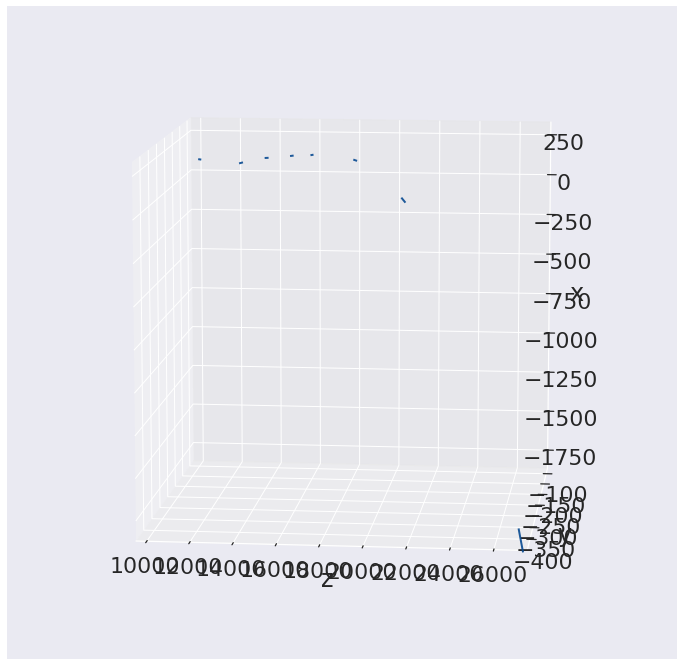

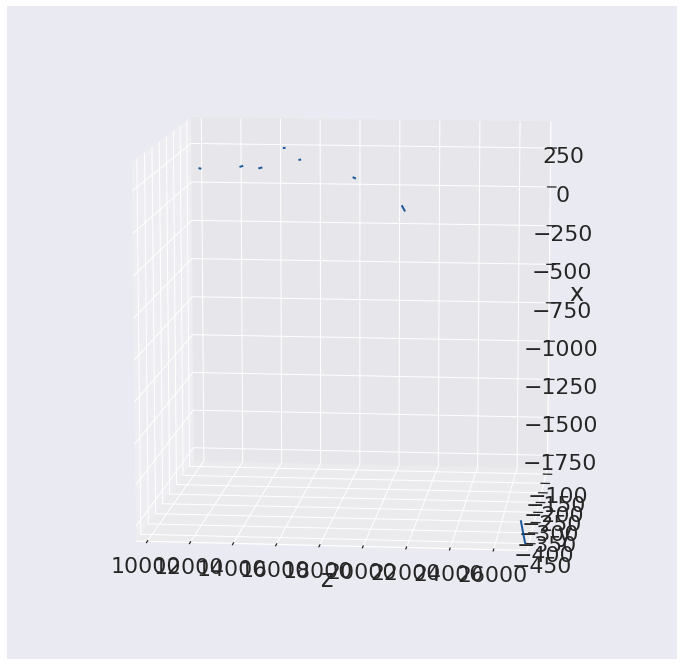

In [89]:
from tools.opera_tools import plot_npframe
plot_npframe(shower.x.cpu().detach().numpy()[0] * np.array([1e3, 1e3, 1e3, 1, 1]))

tmp_X = features.cpu().detach().numpy()[:, :5]
tmp_X *= np.array([1e3, 1e3, 1e3, 1, 1])
plot_npframe(tmp_X)

In [98]:
def get_graph(adj):
    '''
    get a graph from zero-padded adj
    :param adj:
    :return:
    '''
    # remove all zeros rows and columns
    adj = adj[~np.all(adj == 0, axis=1)]
    adj = adj[:, ~np.all(adj == 0, axis=0)]
    adj = np.asmatrix(adj)
    G = nx.from_numpy_matrix(adj)
    return G

def generate_graph(model, edge_nn, max_prev_node, test_batch_energies, device):
    test_batch_size = test_batch_energies.shape[0]
    model.hidden = model.init_hidden(test_batch_energies, test_batch_size)
    model.eval()
    model.eval()

    # generate graphs
    max_num_node = 100
    
    y_pred_long = torch.ones(test_batch_size, 
                             max_num_node, 
                             max_prev_node).to(device) # discrete prediction
    
    x_step = torch.zeros(test_batch_size, 1, max_prev_node).to(device)
    edges_emb = []
    for i in tqdm(range(max_num_node)):
        _, h, _ = model(x_step)
        hidden_null = torch.zeros(edge_nn.num_layers - 1, h.size(0), h.size(2)).cuda()
        edge_nn.hidden = torch.cat((h.permute(1, 0, 2), hidden_null), dim=0)  # num_layers, batch_size, hidden_size
        x_step = torch.zeros(test_batch_size, 1, max_prev_node).to(device)
        output_x_step = torch.ones(test_batch_size, 1, 1).to(device)
        for j in range(min(max_prev_node, i+1)):
            edge_emb, output_y_pred_step, _ = edge_nn(output_x_step)
            edges_emb.append(edge_emb)
            # if j < i + 1:
            output_x_step = Bernoulli(logits=output_y_pred_step).sample()
            x_step[:, :, j:j+1] = output_x_step
            # edge_nn.hidden = hidden.data
        y_pred_long[:, i:i + 1, :] = x_step
        model.hidden = model.hidden.data
    y_pred_long_data = y_pred_long.data.long()
    return edges_emb
    # save graphs as pickle
    G_pred_list = []
    for i in range(test_batch_size):
        adj_pred = decode_adj(y_pred_long_data[i].detach().cpu().numpy())
        G_pred = get_graph(adj_pred) # get a graph from zero-padded adj
        G_pred_list.append(G_pred)
        
        # teacher forcing
        shower_t = torch_geometric.data.Data(x=embedding, 
                                             edge_index=shower.adj_out).to(device)
        
        # GCN to recover shower features
        features = features_nn(shower_t)

    return G_pred_list


a = generate_graph(model=model, 
                   edge_nn=edge_nn,
                   max_prev_node=max_prev_node, 
                   test_batch_energies=torch.tensor([6.6297] * 10).to(device).view(-1, 1), 
                   device=device)

In [108]:
torch.cat(a, dim=1).view(10, 100, -1).shape

torch.Size([10, 100, 2416])

In [96]:
shower_t = torch_geometric.data.Data(x=embedding, 
                                     edge_index=adj_out_t).to(device)

features = features_nn(shower_t)

AttributeError: 'graphrnn_shower' object has no attribute 'adj_out_t'

In [94]:
features

tensor([[ 8.9973e-02, -6.7471e-02,  9.8313e+00,  1.4215e-02, -4.3729e-02],
        [ 1.7245e-01, -1.6644e-01,  1.2505e+01,  5.0486e-02, -1.6039e-02],
        [ 2.0603e-01, -2.2387e-01,  1.3765e+01,  3.6837e-02, -5.2844e-03],
        [ 3.5146e-01, -2.4785e-01,  1.5091e+01,  5.3939e-02, -6.6984e-02],
        [ 3.5669e-01, -3.5803e-01,  1.6422e+01,  7.2556e-02, -7.7285e-02],
        [ 2.7678e-01, -3.8309e-01,  1.9073e+01, -4.6850e-03, -5.2512e-02],
        [ 1.8251e-01, -4.7318e-01,  2.1711e+01, -1.2697e-01, -6.1126e-02],
        [-1.7916e+00, -3.7578e-01,  2.6968e+01, -7.3930e-01,  2.7129e-02]],
       device='cuda:0', grad_fn=<IndexPutBackward>)

In [ ]:
tmp_X = features.cpu().detach().numpy()[:, :5]
tmp_X *= np.array([1e3, 1e3, 1e3, 1, 1])
plot_npframe(tmp_X)